# Team Based Model

## Imports

In [108]:

import sqlite3
import joblib
import optuna

import pandas as pd
# import plotly.graph_objects as go
# import plotly.express as px

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.compose import ColumnTransformer
import seaborn as sns

# import tensorflow as tf 
# from tensorflow import keras
# from tensorflow.keras import layers

from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
def load_team_data(conn, start_season, end_season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""
    

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)
    tracking = pd.read_sql("SELECT * FROM team_tracking_boxscores", connection)

    basic = basic.loc[basic['SEASON'].between(start_season, end_season)]
    basic[['GAME_ID', 'TEAM_ID']] = basic[['GAME_ID', 'TEAM_ID']].astype(str)
    adv[['GAME_ID', 'TEAM_ID']] = adv[['GAME_ID', 'TEAM_ID']].astype(str)
    scoring[['GAME_ID', 'TEAM_ID']] = scoring[['GAME_ID', 'TEAM_ID']].astype(str)
    tracking[['GAME_ID', 'TEAM_ID']] = tracking[['GAME_ID', 'TEAM_ID']].astype(str)

    df = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(df, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    
    df = pd.merge(df, tracking, how='left', on=['GAME_ID', 'TEAM_ID'],
                  suffixes=['', '_y'])
    

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y',
                          'FG_PCT_y', 'AST_y'])
    
    return df


start_season = '2013-14'
end_season = '2021-22'

connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection, start_season, end_season)
connection.close()

In [4]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    return df


clean_df = clean_team_data(df)
clean_df

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,HOME_GAME
0,2013-14,1610612746,LAC,Los Angeles Clippers,0021300003,2013-10-29,LAC @ LAL,0,240,41,83,0.494,8,21,0.381,13,23,0.565,10,30,40,27,11,4,16,21,103,-13,103.9,105.1,109.1,117.2,-5.2,-12.1,0.659,1.69,19.8,0.255,0.561,0.423,16.142,16.3,0.542,0.553,1.0,0.200,102.72,98.5,82.08,98,0.497,0.747,0.253,0.641,0.175,0.233,0.184,0.126,0.243,0.466,0.606,0.394,0.875,0.125,0.659,0.341,17.44,40,64,98,394,0,2,279,23,44,0.523,18,39,0.462,12,21,0.571,0
1,2013-14,1610612747,LAL,Los Angeles Lakers,0021300003,2013-10-29,LAL vs. LAC,1,240,42,93,0.452,14,29,0.483,18,28,0.643,18,34,52,23,8,6,19,23,116,13,109.1,117.2,103.9,105.1,5.2,12.1,0.548,1.21,15.6,0.439,0.745,0.577,17.871,19.2,0.527,0.551,1.0,0.195,102.72,98.5,82.08,99,0.503,0.688,0.312,0.483,0.121,0.362,0.112,0.155,0.241,0.362,0.429,0.571,0.786,0.214,0.548,0.452,17.35,44,64,103,449,4,0,318,15,31,0.484,27,62,0.435,20,28,0.714,1
2,2013-14,1610612741,CHI,Chicago Bulls,0021300002,2013-10-29,CHI @ MIA,0,240,35,83,0.422,7,26,0.269,18,23,0.783,11,30,41,23,11,4,19,27,95,-12,93.9,96.9,107.3,108.1,-13.3,-11.1,0.657,1.21,17.0,0.294,NaN,NaN,18.790,19.4,0.464,0.510,1.0,0.198,100.44,98.5,82.08,98,0.401,0.687,0.313,0.589,0.063,0.221,0.179,0.189,0.316,0.526,0.571,0.429,1.000,0.000,0.657,0.343,17.64,37,57,87,446,3,3,317,17,35,0.486,18,48,0.375,11,20,0.550,0
3,2013-14,1610612748,MIA,Miami Heat,0021300002,2013-10-29,MIA vs. CHI,1,240,37,72,0.514,11,20,0.550,22,29,0.759,5,35,40,26,10,7,20,21,107,12,107.3,108.1,93.9,96.9,13.3,11.1,0.703,1.30,19.9,NaN,0.706,NaN,20.048,20.2,0.590,0.631,1.0,0.197,100.44,98.5,82.08,99,0.599,0.722,0.278,0.486,0.168,0.308,0.093,0.206,0.140,0.318,0.577,0.423,1.000,0.000,0.703,0.297,17.01,22,73,93,462,3,3,340,11,28,0.393,26,44,0.591,17,26,0.654,1
4,2013-14,1610612754,IND,Indiana Pacers,0021300001,2013-10-29,IND vs. ORL,1,240,34,71,0.479,7,17,0.412,22,32,0.688,10,34,44,17,4,18,21,13,97,10,101.0,103.2,84.1,92.6,16.8,10.6,0.500,0.81,13.8,0.317,0.617,0.495,21.857,22.3,0.528,0.570,1.0,0.198,99.74,94.0,78.33,94,0.661,0.761,0.239,0.557,0.186,0.216,0.134,0.227,0.299,0.371,0.444,0.556,0.714,0.286,0.500,0.500,16.09,40,78,117,428,1,1,310,20,38,0.526,14,33,0.424,9,21,0.429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23001,2021-22,1610612744,GSW,Golden State Warriors,0042100404,2022-06-10,GSW @ BOS,1,240,40,91,0.440,15,43,0.349,12,15,0.800,16,39,55,20,10,5,16,21,107,10,109.6,111.5,98.6,101.0,11.0,10.4,0.500,1.25,15.0,0.385,0.736,0.562,16.393,16.7,0.522,0.548,1.0,0.201,97.98,96.0,80.00,96,0.552,0.527,0.473,0.467,0.112,0.421,0.075,0.112,0.178,0.355,0.400,0.600,0.667,0.333,0.500,0.500,17.19,28,60,85,373,3,2,247,20,38,0.526,20,53,0.377,12,18,0.667,0
23002,2021-22,1610612738,BOS,Boston Celtics,0042100405,2022-06-13,BOS @ GSW,0,240,31,75,0.413,11,32,0.344,21,31,0.677,8,39,47,18,2,2,18,16,94,-10,95.3,95.9,106.6,107.2,-11.3,-11.3,0.581,1.00,14.4,0.250,0.894,0.568,18.248,18.4,0.487,0.530,1.0,0.201,98.12,97.5,81.25,98,0.438,0.573,0.427,0.426,0.043,0.351,0.085,0.223,0.096,0.383,0.500,0.500,0.727,0.273,0.581,0.419,17.06,17,58,75,397,1,2,278,12,27,0.444,19,48,

In [5]:
# from src.data.make_team_dataset import prep_for_aggregation

def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE_PER40', 'MIN', 'PIE', 'CFG_PCT', 'UFG_PCT',
                          'DFG_PCT', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    df = df.drop(columns = ['PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT',
                          'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB',
                          'PCT_PTS_FT','PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 
                          'PCT_AST_2PM', 'PCT_UAST_2PM','PCT_AST_3PM',
                          'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM',
                          'E_PACE'])
    
    ## Reorder Columns
    
    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'TEAM_SCORE', 'WL', 'POINT_DIFF', 'HOME_GAME', 'RECORD',
       'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'PACE',
       'POSS', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS',
       'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM', 'DFGA', 'PTS_2PT_MR', 'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM',
       'AST_3PM', 'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,TEAM_SCORE,WL,POINT_DIFF,HOME_GAME,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM
0,2013-14,1610612746,LAC,Los Angeles Clippers,0021300003,2013-10-29,LAC @ LAL,103,0,-13,0,0,33,62,8,21,13,23,10,30,40,27,11,4,16,21,103,-13,105.1,117.2,-12.1,98.5,98,17.44,40,64,98,394,0,2,279,23,44,18,39,12,21,18,18,25,47,19,7,13,1
1,2013-14,1610612747,LAL,Los Angeles Lakers,0021300003,2013-10-29,LAL vs. LAC,116,1,13,1,1,28,64,14,29,18,28,18,34,52,23,8,6,19,23,116,13,117.2,105.1,12.1,98.5,99,17.35,44,64,103,449,4,0,318,15,31,27,62,20,28,14,12,27,41,12,11,15,2
2,2013-14,1610612741,CHI,Chicago Bulls,0021300002,2013-10-29,CHI @ MIA,95,0,-12,0,0,28,57,7,26,18,23,11,30,41,23,11,4,19,27,95,-12,96.9,108.1,-11.1,98.5,98,17.64,37,57,87,446,3,3,317,17,35,18,48,11,20,5,17,30,49,15,7,12,0
3,2013-14,1610612748,MIA,Miami Heat,0021300002,2013-10-29,MIA vs. CHI,107,1,12,1,1,26,52,11,20,22,29,5,35,40,26,10,7,20,21,107,12,108.1,96.9,11.1,98.5,99,17.01,22,73,93,462,3,3,340,11,28,26,44,17,26,17,9,14,34,15,11,10,0
4,2013-14,1610612754,IND,Indiana Pacers,0021300001,2013-10-29,IND vs. ORL,97,1,10,1,1,27,54,7,17,22,32,10,34,44,17,4,18,21,13,97,10,103.2,92.6,10.6,94.0,94,16.09,40,78,117,428,1,1,310,20,38,14,33,9,21,18,12,29,35,11,4,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23001,2021-22,1610612744,GSW,Golden State Warriors,0042100404,2022-06-10,GSW @ BOS,107,1,10,0,1,25,48,15,43,12,15,16,39,55,20,10,5,16,21,107,10,111.5,101.0,10.4,96.0,96,17.19,28,60,85,373,3,2,247,20,38,20,53,12,18,11,8,19,37,10,10,15,4
23002,2021-22,1610612738,BOS,Boston Celtics,0042100405,2022-06-13,BOS @ GSW,94,0,-10,0,0,20,43,11,32,21,31,8,39,47,18,2,2,18,16,94,-10,95.9,107.2,-11.3,97.5,98,17.06,17,58,75,397,1,2,278,12,27,19,48,14,22,4,7,9,36,10,7,10,3
23003,2021-22,1610612744,GSW,Golden State Warriors,0042100405,2022-06-13,GSW vs. BOS,104,1,10,1,1,32,48,9,40,13,15,4,35,39,23,9,2,7,28,104,10,107.2,95.9,11.3,97.5,97,17.59,20,52,68,379,1,2,265,19,30,22,58,14,24,14,11,22,50,16,7,16,1
23004,2021-22,1610612738,BOS,Boston Celtics,0042100406,2022-06-16,BOS vs. GSW,90,0,-13,1,0,23,52,11,28,11,12,11,30,41,27,8,8,23,16,90,-13,96.8,109.6,-12.8,93.5,93,16.48,33,47,80,400,5,2,276,15,40,19,40,13,25,8,11,27,37,16,9,6,1


## Add Betting Data 

In [6]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [7]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [8]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)
    
    moneylines['GM_DATE'] = pd.to_datetime(moneylines['GM_DATE'])

    return moneylines

In [9]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_29168\4006584993.py:33: RuntimeWarning: All-NaN axis encountered
  abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_29168\4006584993.py:39: RuntimeWarning: All-NaN axis encountered
  abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)


In [10]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.replace('None', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan).replace('None', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)
    spreads['GM_DATE'] = pd.to_datetime(spreads['GM_DATE'])

    return spreads

In [11]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_29168\1082226645.py:53: RuntimeWarning: All-NaN axis encountered
  lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_29168\1082226645.py:58: RuntimeWarning: All-NaN axis encountered
  lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)


In [12]:
clean_spreads

,SEASON,GM_DATE,HOME_TEAM,AWAY_TEAM,HIGHEST_HOME_SPREAD,HIGHEST_AWAY_SPREAD
0,2006-07,2006-10-31,MIA,CHI,-4.5,4.5
1,2006-07,2006-10-31,LAL,PHX,8.5,-8.5
2,2006-07,2006-11-02,DAL,SAS,-3.0,3.0
3,2006-07,2006-11-02,LAC,DEN,-4.5,4.5
4,2006-07,2006-11-03,MEM,CHA,-5.0,5.0
...,...,...,...,...,...,...
20197,2021-22,2022-06-05,GSW,BOS,-5.5,5.0
20198,2021-22,2022-06-08,BOS,GSW,-3.5,3.5
20199,2021-22,2022-06-10,BOS,GSW,-4.0,4.0
20200,2021-22,2022-06-13,GSW,BOS,-4.0,4.0


In [13]:
clean_mls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SEASON           20200 non-null  object        
 1   GM_DATE          20200 non-null  datetime64[ns]
 2   HOME_TEAM        20200 non-null  object        
 3   AWAY_TEAM        20200 non-null  object        
 4   HIGHEST_HOME_ML  18507 non-null  float64       
 5   HIGHEST_AWAY_ML  18506 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 947.0+ KB


In [14]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [15]:
merged_df.iloc[:, 34:-4]

,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM
0,40,64,98,394,0,2,279,23,44,18,39,12,21,18,18,25,47,19,7,13,1
1,44,64,103,449,4,0,318,15,31,27,62,20,28,14,12,27,41,12,11,15,2
2,37,57,87,446,3,3,317,17,35,18,48,11,20,5,17,30,49,15,7,12,0
3,22,73,93,462,3,3,340,11,28,26,44,17,26,17,9,14,34,15,11,10,0
4,40,78,117,428,1,1,310,20,38,14,33,9,21,18,12,29,35,11,4,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23001,28,60,85,373,3,2,247,20,38,20,53,12,18,11,8,19,37,10,10,15,4
23002,17,58,75,397,1,2,278,12,27,19,48,14,22,4,7,9,36,10,7,10,3
23003,20,52,68,379,1,2,265,19,30,22,58,14,24,14,11,22,50,16,7,16,1
23004,33,47,80,400,5,2,276,15,40,19,40,13,25,8,11,27,37,16,9,6,1


In [16]:
def normalize_per_100_poss(df):
    df = df.copy(deep=True)
    
    df.iloc[:, 12:27] = 100*df.iloc[:, 12:27].div(df['PACE'], axis=0) 
    df.iloc[:,  34:-4] = 100*df.iloc[:, 34:-4].div(df['PACE'], axis=0) 
    
    return df

stats_per_100 = normalize_per_100_poss(merged_df)
stats_per_100.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,TEAM_SCORE,WL,POINT_DIFF,HOME_GAME,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED
0,2013-14,1610612746,LAC,Los Angeles Clippers,0021300003,2013-10-29,LAC @ LAL,103,0,-13,0,0,33.502538,62.944162,8.121827,21.319797,13.197970,23.350254,10.152284,30.456853,40.609137,27.411168,11.167513,4.060914,16.243655,21.319797,104.568528,-13,105.1,117.2,-12.1,98.5,98,17.44,40.609137,64.974619,99.492386,400.000000,0.000000,2.030457,283.248731,23.350254,44.670051,18.274112,39.593909,12.182741,21.319797,18.274112,18.274112,25.380711,47.715736,19.289340,7.106599,13.197970,1.015228,1.156250,-10.0,-23.0,0
1,2013-14,1610612747,LAL,Los Angeles Lakers,0021300003,2013-10-29,LAL vs. LAC,116,1,13,1,1,28.426396,64.974619,14.213198,29.441624,18.274112,28.426396,18.274112,34.517766,52.791878,23.350254,8.121827,6.091371,19.289340,23.350254,117.766497,13,117.2,105.1,12.1,98.5,99,17.35,44.670051,64.974619,104.568528,455.837563,4.060914,0.000000,322.842640,15.228426,31.472081,27.411168,62.944162,20.304569,28.426396,14.213198,12.182741,27.411168,41.624365,12.182741,11.167513,15.228426,2.030457,5.550000,10.0,23.0,1
2,2013-14,1610612741,CHI,Chicago Bulls,0021300002,2013-10-29,CHI @ MIA,95,0,-12,0,0,28.426396,57.868020,7.106599,26.395939,18.274112,23.350254,11.167513,30.456853,41.624365,23.350254,11.167513,4.060914,19.289340,27.411168,96.446701,-12,96.9,108.1,-11.1,98.5,98,17.64,37.563452,57.868020,88.324873,452.791878,3.045685,3.045685,321.827411,17.258883,35.532995,18.274112,48.730964,11.167513,20.304569,5.076142,17.258883,30.456853,49.746193,15.228426,7.106599,12.182741,0.000000,2.850000,5.0,-7.0,0
3,2013-14,1610612748,MIA,Miami Heat,0021300002,2013-10-29,MIA vs. CHI,107,1,12,1,1,26.395939,52.791878,11.167513,20.304569,22.335025,29.441624,5.076142,35.532995,40.609137,26.395939,10.152284,7.106599,20.304569,21.319797,108.629442,12,108.1,96.9,11.1,98.5,99,17.01,22.335025,74.111675,94.416244,469.035533,3.045685,3.045685,345.177665,11.167513,28.426396,26.395939,44.670051,17.258883,26.395939,17.258883,9.137056,14.213198,34.517766,15.228426,11.167513,10.152284,0.000000,1.454545,-5.0,7.0,1
4,2013-14,1610612754,IND,Indiana Pacers,0021300001,2013-10-29,IND vs. ORL,97,1,10,1,1,28.723404,57.446809,7.446809,18.085106,23.404255,34.042553,10.638298,36.170213,46.808511,18.085106,4.255319,19.148936,22.340426,13.829787,103.191489,10,103.2,92.6,10.6,94.0,94,16.09,42.553191,82.978723,124.468085,455.319149,1.063830,1.063830,329.787234,21.276596,40.425532,14.893617,35.106383,9.574468,22.340426,19.148936,12.765957,30.851064,37.234043,11.702128,4.255319,15.957447,2.127660,1.090498,-12.5,-2.5,0


In [17]:
stats_per_100.loc[(stats_per_100['GAME_DATE'] == '2021-10-20')
                  &(stats_per_100['TEAM_ABBREVIATION'] == 'BOS')]

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,TEAM_SCORE,WL,POINT_DIFF,HOME_GAME,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED
20389,2021-22,1610612738,BOS,Boston Celtics,0022100005,2021-10-20,BOS @ NYK,134,0,-4,0,0,26.205959,58.235465,20.382413,55.323692,16.500049,22.323595,14.558866,39.794235,54.353101,33.000097,12.617684,8.73532,17.47064,23.294186,130.059206,-4,108.1,110.4,-2.3,103.03,124,20.49,39.794235,53.38251,89.29438,469.766088,6.794138,2.911773,317.383286,11.647093,29.117733,34.941279,84.441425,22.323595,31.058915,11.647093,18.441231,16.500049,39.794235,15.529457,16.500049,9.705911,2.911773,2.2,3.5,-0.5,0


In [18]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df.iloc[:, :-4], df, on=['GAME_ID'], suffixes=['', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp',
                             'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_NAME_opp',
                                       'TEAM_ID_opp', 'WL_opp', ]
                 )
    
    matchups
    
    return matchups


matchups = create_matchups(stats_per_100)
matchups.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,TEAM_SCORE,WL,POINT_DIFF,HOME_GAME,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,TEAM_SCORE_opp,POINT_DIFF_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,ML,SPREAD,ATS_DIFF,TEAM_COVERED
1,2013-14,1610612746,LAC,Los Angeles Clippers,0021300003,2013-10-29,LAC @ LAL,103,0,-13,0,0,33.502538,62.944162,8.121827,21.319797,13.197970,23.350254,10.152284,30.456853,40.609137,27.411168,11.167513,4.060914,16.243655,21.319797,104.568528,-13,105.1,117.2,-12.1,98.5,98,17.44,40.609137,64.974619,99.492386,400.000000,0.000000,2.030457,283.248731,23.350254,44.670051,18.274112,39.593909,12.182741,21.319797,18.274112,18.274112,25.380711,47.715736,19.289340,7.106599,13.197970,1.015228,116,13,1,28.426396,64.974619,14.213198,29.441624,18.274112,28.426396,18.274112,34.517766,52.791878,23.350254,8.121827,6.091371,19.289340,23.350254,117.766497,13,117.2,105.1,12.1,98.5,99,17.35,44.670051,64.974619,104.568528,455.837563,4.060914,0.000000,322.842640,15.228426,31.472081,27.411168,62.944162,20.304569,28.426396,14.213198,12.182741,27.411168,41.624365,12.182741,11.167513,15.228426,2.030457,5.550000,10.0,23.0,1
2,2013-14,1610612747,LAL,Los Angeles Lakers,0021300003,2013-10-29,LAL vs. LAC,116,1,13,1,1,28.426396,64.974619,14.213198,29.441624,18.274112,28.426396,18.274112,34.517766,52.791878,23.350254,8.121827,6.091371,19.289340,23.350254,117.766497,13,117.2,105.1,12.1,98.5,99,17.35,44.670051,64.974619,104.568528,455.837563,4.060914,0.000000,322.842640,15.228426,31.472081,27.411168,62.944162,20.304569,28.426396,14.213198,12.182741,27.411168,41.624365,12.182741,11.167513,15.228426,2.030457,103,-13,0,33.502538,62.944162,8.121827,21.319797,13.197970,23.350254,10.152284,30.456853,40.609137,27.411168,11.167513,4.060914,16.243655,21.319797,104.568528,-13,105.1,117.2,-12.1,98.5,98,17.44,40.609137,64.974619,99.492386,400.000000,0.000000,2.030457,283.248731,23.350254,44.670051,18.274112,39.593909,12.182741,21.319797,18.274112,18.274112,25.380711,47.715736,19.289340,7.106599,13.197970,1.015228,1.156250,-10.0,-23.0,0
5,2013-14,1610612741,CHI,Chicago Bulls,0021300002,2013-10-29,CHI @ MIA,95,0,-12,0,0,28.426396,57.868020,7.106599,26.395939,18.274112,23.350254,11.167513,30.456853,41.624365,23.350254,11.167513,4.060914,19.289340,27.411168,96.446701,-12,96.9,108.1,-11.1,98.5,98,17.64,37.563452,57.868020,88.324873,452.791878,3.045685,3.045685,321.827411,17.258883,35.532995,18.274112,48.730964,11.167513,20.304569,5.076142,17.258883,30.456853,49.746193,15.228426,7.106599,12.182741,0.000000,107,12,1,26.395939,52.791878,11.167513,20.304569,22.335025,29.441624,5.076142,35.532995,40.609137,26.395939,10.152284,7.106599,20.304569,21.319797,108.629442,12,108.1,96.9,11.1,98.5,99,17.01,22.335025,74.111675,94.416244,469.035533,3.045685,3.045685,345.177665,11.167513,28.426396,26.395939,44.670051,17.258883,26.395939,17.258883,9.137056,14.213198,34.517766,15.228426,11.167513,10.152284,0.000000,1.454545,-5.0,7.0,1
6,2013-14,1610612748,MIA,Miami Heat,0021300002,2013-10-29,MIA vs. CHI,107,1,12,1,1,26.395939,52.791878,11.167513,20.304569,22.335025,29.441624,5.076142,35.532995,40.609137,26.395939,10.152284,7.106599,20.304569,21.319797,108.629442,12,108.1,96.9,11.1,98.5,99,17.01,22.335025,74.111675,94.416244,469.035533,3.045685,3.045685,345.177665,11.167513,28.426396,26.395939,44.670051,17.258883,26.395939,17.258883,9

## Using a teams running average to predict stats

In [20]:
stat='PTS'
df = matchups
n = 10

matchup_info = df[['SEASON', 'GAME_ID', 'TEAM_ABBREVIATION', 'GAME_DATE', 'HOME_GAME', 'MATCHUP', stat]]
avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].rolling(n).mean().reset_index()
avg_stats.set_index('level_1')

avg_stats = pd.merge(matchup_info, avg_stats[stat], left_index=True, right_index=True, suffixes=['_true', '_pred'])
avg_stats.iloc[10000:10001]

,SEASON,GAME_ID,TEAM_ABBREVIATION,GAME_DATE,HOME_GAME,MATCHUP,PTS_true,PTS_pred
20001,2016-17,0021601056,SAS,2017-03-21,0,SAS @ MIN,109.289617,108.844629


In [21]:
stat='PTS'
df = matchups
n = 10

matchup_info = df[['SEASON', 'GAME_ID', 'TEAM_ABBREVIATION', 'GAME_DATE', 'HOME_GAME', 'MATCHUP', stat]]
avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].rolling(n).mean().reset_index()
# avg_stats.set_index('level_1')

avg_stats = pd.merge(matchup_info, avg_stats[stat], left_index=True, right_index=True, suffixes=['_true', '_pred'])
avg_stats.iloc[10000:10001]

,SEASON,GAME_ID,TEAM_ABBREVIATION,GAME_DATE,HOME_GAME,MATCHUP,PTS_true,PTS_pred
20001,2016-17,0021601056,SAS,2017-03-21,0,SAS @ MIN,109.289617,108.844629


In [22]:
def avg_model(df, stat, avg_method='running', n=10):
    matchup_info = df[['SEASON', 'GAME_ID', 'TEAM_ABBREVIATION', 'GAME_DATE', 'HOME_GAME', 'MATCHUP', stat]]

    if avg_method == 'running':
        avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].expanding().mean().reset_index()
        
    elif avg_method == 'moving':
        avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].rolling(n).mean().reset_index()
        
    elif avg_method == 'ewma':
        avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].apply(lambda x: x.ewm(span=n).mean()).reset_index()
        avg_stats['level_1'] = avg_stats['index']
#         avg_stats = pd.concat([df[['SEASON', 'TEAM_ABBREVIATION']], avg_stats], axis=1)
        
    else:
        print("Not a valid avg_method. Enter 'running', 'moving', or 'ewma'")
        return None
    
    avg_stats = avg_stats.set_index('level_1')

    avg_stats = pd.merge(matchup_info, avg_stats[stat], left_index=True, right_index=True, suffixes=['_true', '_pred'])

    stat_pred = stat + '_pred'
    stat_true = stat + '_true'
    
    avg_stats = avg_stats.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'])
    
    avg_stats[stat_pred] = avg_stats.groupby(['TEAM_ABBREVIATION'])[stat_pred].shift(1)

    avg_stats = avg_stats[['SEASON', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'HOME_GAME',
                                  stat_pred, stat_true]]

    avg_stats = avg_stats.dropna()
    
    return avg_stats


In [23]:
test = avg_model(matchups, 'PTS', 'ewma', n=40)

np.mean(np.abs(test['PTS_pred'] - test['PTS_true']))

9.06340109765158

In [24]:
def calc_metrics(df, stat, print_result = True):
    stat_pred = stat + '_pred'
    stat_true = stat + '_true'
    mae = mean_absolute_error(df[stat_true], df[stat_pred])
    rmse = mean_squared_error(df[stat_true], df[stat_pred], squared=False)
    r2 = r2_score(df[stat_true], df[stat_pred])
    if print_result == True:
        print("mean_absolute_error:", mae)
        print("root_mean_squared_error:", rmse)
        print("R2:", r2)
    
    return mae, rmse, r2
    


In [77]:

def build_team_avg_stats_df(df: pd.DataFrame, span = 10) -> pd.DataFrame:    
    """This function finds the average for each team and opp statistic up to (and NOT including) the given date.
    """
    
    df = df.copy(deep=True)

    df = df.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)

    

    drop_cols = ['TEAM_ID', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 
                 'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 
                'GAME_DATE', 'POINT_DIFF', 'WL', 'TEAM_SCORE_opp',
                'POINT_DIFF_opp']

    stats = df.drop(columns=drop_cols)

    avg_stat_holder = []

    for stat in stats.columns[2:]:
        avg_stats = stats.groupby(['TEAM_ABBREVIATION'])[stat].ewm(span=span).mean().reset_index(drop=True)
        avg_stat_holder.append(avg_stats)

    

    matchup_info = df[['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE',
                          'GAME_ID', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE',
                          'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 
                          'POINT_DIFF', 'WL']]   

    avg_stats = pd.concat(avg_stat_holder, axis=1)
    
    avg_stats= avg_stats.rename(columns={'ATS_DIFF':'AVG_ATS_DIFF',
                                    'TEAM_COVERED':'AVG_COVER_PCT'})

    avg_stats = pd.concat([matchup_info, avg_stats], axis=1)
    
    avg_stats = avg_stats.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'])
    avg_stats.iloc[:, 13:] = avg_stats.iloc[:, 13:].shift(1).where(avg_stats['TEAM_ABBREVIATION'].eq(avg_stats['TEAM_ABBREVIATION'].shift()))

    return avg_stats

team_stats_ewa = build_team_avg_stats_df(matchups, span=5)

team_stats_ewa.loc[team_stats_ewa['TEAM_ABBREVIATION'] == 'SAS'].sort_values('GAME_DATE')



,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,AVG_ATS_DIFF,AVG_COVER_PCT
19879,2013-14,SAS,2013-10-30,0021300013,SAS vs. MEM,1,101,3.10000,6.0,-1.0,0,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19880,2013-14,SAS,2013-11-01,0021300032,SAS @ LAL,0,91,3.85000,7.5,1.5,1,6,1,1.000000,30.526316,58.947368,11.578947,21.052632,10.526316,16.842105,4.210526,37.894737,42.105263,26.315789,3.157895,6.315789,15.789474,18.947368,106.315789,7.000000,106.300000,98.900000,7.400000,95.000000,95.000000,17.490000,18.947368,85.263158,100.000000,448.421053,5.263158,2.105263,328.421053,21.052632,35.789474,21.052632,44.210526,10.526316,22.105263,7.368421,18.947368,15.789474,51.578947,14.736842,9.473684,14.736842,1.052632,0.000000,32.631579,82.105263,8.421053,15.789474,8.421053,15.789474,11.578947,34.736842,46.315789,25.263158,6.315789,3.157895,14.736842,15.789474,98.947368,-7.000000,98.900000,106.300000,-7.400000,95.000000,95.000000,17.320000,45.263158,51.578947,92.631579,470.526316,3.157895,2.105263,345.263158,18.947368,51.578947,22.105263,46.315789,20.000000,28.421053,22.105263,10.526316,15.789474,42.105263,15.789474,8.421053,15.789474,0.000000,-1.000000,0.000000
19881,2013-14,SAS,2013-11-02,0021300039,SAS @ POR,0,105,2.20000,2.5,12.5,1,-10,0,1.000000,33.052632,69.684211,7.789474,21.684211,10.526316,15.578947,9.263158,39.157895,48.421053,23.157895,5.684211,2.526316,13.894737,18.947368,100.000000,6.400000,100.000000,93.260000,6.740000,95.000000,95.000000,17.766000,35.368421,73.894737,106.947368,458.526316,4.000000,1.473684,335.368421,18.526316,42.736842,22.315789,48.631579,9.263158,17.684211,19.368421,12.631579,17.684211,45.894737,15.368421,6.947368,16.631579,0.421053,0.000000,26.947368,67.578947,8.421053,23.368421,14.105263,21.473684,9.684211,37.894737,47.578947,24.000000,5.052632,5.684211,13.473684,18.315789,93.263158,-6.400000,93.260000,100.000000,-6.740000,95.000000,95.000000,17.356000,35.157895,71.789474,103.368421,441.473684,3.157895,0.842105,318.736842,15.157895,39.578947,20.210526,51.368421,16.842105,28.421053,15.789474,10.526316,12.631579,36.421053,15.789474,7.789474,10.105263,0.631579,0.500000,0.600000
19882,2013-14,SAS,2013-11-05,0021300057,SAS @ DEN,0,102,2.70000,5.0,-3.0,0,8,1,0.526316,37.315150,76.513957,7.014703,17.242702,7.969316,12.086086,10.705306,31.783507,42.488813,23.848285,5.906670,2.301300,13.142979,22.118048,103.643725,-1.368421,103.363158,105.263158,-1.852632,96.184211,96.421053,17.838947,33.675687,66.584274,98.555295,452.179842,2.591093,0.775623,329.060303,20.924782,41.440443,23.405071,52.316216,11.676966,19.509908,24.768805,7.134029,14.651609,48.932453,17.805242,5.599830,18.470062,0.707437,0.473684,32.158534,65.203495,8.318773,22.015768,15.682932,20.532708,8.497763,35.491157,43.988920,26.720648,4.116770,6.392499,14.864692,16.927339,104.956318,1.368421,105.263158,103.363158,1.852632,96.184211,95.947368,17.585263,33.079054,71.792031,102.50

In [79]:
def build_league_avg_stats_df(df):
    """This function finds the league average for each statistic per season up to (and NOT including) the given date.
    """
    df = df.copy()
    
    df = df.drop(columns=['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED',
       'POINT_DIFF', 'WL', 'RECORD'])

    grouped_df = df.groupby(['SEASON', 'GAME_DATE']).agg(['sum', 'count']).reset_index()
    grouped_df_cum = grouped_df.groupby(['SEASON']).cumsum().reset_index(drop=True)

    cum_stats_per_date = {}
    cum_stats_per_date['SEASON'] = grouped_df['SEASON']
    cum_stats_per_date['GAME_DATE'] = grouped_df['GAME_DATE']
    
    for col in grouped_df_cum.columns.get_level_values(0):
        avg = grouped_df_cum[col]['sum'] / grouped_df_cum[col]['count']
        
        cum_stats_per_date[col] = avg
        
    cum_stats_per_date = pd.DataFrame(cum_stats_per_date).sort_values('GAME_DATE')
    cum_stats_per_date.iloc[:, 2:] = cum_stats_per_date.iloc[:, 2:].shift(1)
    
    cum_stats_per_date = cum_stats_per_date.add_suffix('_LA')
    
    cum_stats_per_date = cum_stats_per_date.rename(columns={'SEASON_LA':'SEASON', 'GAME_DATE_LA':'GAME_DATE'})
        
    return cum_stats_per_date
    

league_avg_stats = build_league_avg_stats_df(stats_per_100)
league_avg_stats

C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_29168\1974283373.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  grouped_df_cum = grouped_df.groupby(['SEASON']).cumsum().reset_index(drop=True)


,SEASON,GAME_DATE,FG2M_LA,FG2A_LA,FG3M_LA,FG3A_LA,FTM_LA,FTA_LA,OREB_LA,DREB_LA,REB_LA,AST_LA,STL_LA,BLK_LA,TOV_LA,PF_LA,PTS_LA,PLUS_MINUS_LA,OFF_RATING_LA,DEF_RATING_LA,NET_RATING_LA,PACE_LA,POSS_LA,DIST_LA,ORBC_LA,DRBC_LA,RBC_LA,TCHS_LA,SAST_LA,FTAST_LA,PASS_LA,CFGM_LA,CFGA_LA,UFGM_LA,UFGA_LA,DFGM_LA,DFGA_LA,PTS_2PT_MR_LA,PTS_FB_LA,PTS_OFF_TOV_LA,PTS_PAINT_LA,AST_2PM_LA,AST_3PM_LA,UAST_2PM_LA,UAST_3PM_LA
0,2013-14,2013-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,2013-10-30,29.033013,62.458149,9.605069,22.626634,16.978075,24.874896,11.523023,32.465709,43.988732,22.779638,9.250459,7.808619,19.613349,22.481729,103.859308,0.0,103.850000,103.850000,0.000000e+00,97.000000,97.000000,17.043333,40.153724,67.768298,103.474097,443.795226,2.046657,1.530943,316.969975,17.727796,39.130396,20.910285,45.954387,14.230298,23.343954,15.874644,13.376175,24.931598,41.168053,13.867588,8.041725,14.133996,1.039529
2,2013-14,2013-10-31,30.167767,63.028128,8.236339,21.489982,18.061842,24.644024,10.623191,32.467354,43.090545,21.846856,8.234577,5.869893,17.969809,22.848289,103.106393,0.0,102.458824,102.458824,0.000000e+00,96.846471,97.470588,16.982941,35.045442,64.273045,96.088620,432.125387,2.191121,1.946505,307.581564,17.092559,38.152311,21.138350,46.073859,14.360940,23.507155,18.001209,15.209501,19.164916,41.299717,14.458297,6.752665,14.831313,1.208885
3,2013-14,2013-11-01,29.954447,62.715390,8.236711,21.602585,18.327344,25.056147,10.904643,32.175387,43.080030,22.020270,8.405928,5.721213,18.154547,23.211420,102.946371,0.0,102.368421,102.368421,0.000000e+00,97.020526,97.578947,16.881842,35.800073,63.813960,96.419730,427.625551,2.337315,1.869226,303.608940,17.071229,38.141307,20.906483,45.623061,14.293488,23.470549,17.770552,15.298669,19.117551,41.158805,14.669715,6.673929,14.391344,1.263085
4,2013-14,2013-11-02,29.915777,63.868616,8.002773,21.521141,19.393497,26.659643,11.579612,32.619413,44.199026,21.587076,8.313287,5.526029,17.276477,23.690646,103.233371,0.0,102.539062,102.539062,0.000000e+00,96.447188,97.078125,16.957031,37.102309,65.695297,99.572065,434.508240,2.562918,1.830899,309.014177,17.561363,39.602342,20.230454,45.458711,14.105067,23.303792,16.995895,15.017298,18.323367,41.777088,14.400417,6.486898,14.672128,1.139966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,2021-22,2022-06-05,28.464632,53.486092,12.611523,35.668407,17.231911,22.223201,10.444859,34.514375,44.959234,24.893718,7.685570,4.768411,13.934763,20.057479,111.995745,0.0,111.400076,111.400076,1.417396e-18,98.578399,99.104802,17.796833,24.692302,55.634655,78.024629,411.201445,3.291638,2.428174,288.410007,17.238369,34.413404,23.670494,54.350350,16.884367,25.975233,8.776408,12.122283,15.983176,47.194669,14.175536,9.959853,13.495272,2.033486
1836,2021-22,2022-06-08,28.458185,53.481289,12.613636,35.670143,17.229333,22.220727,10.441591,34.516600,44.958191,24.893897,7.687528,4.768294,13.936258,20.055873,111.986609,0.0,111.391432,111.391432,1.416317e-18,98.577578,99.103580,17.796561,24.689118,55.639152,78.027305,411.199163,3.292646,2.428278,288.405945,17.236176,34.414925,23.668480,54.346060,16.882444,25.975760,8.774801,12.122424,15.988969,47.183721,14.175676,9.960470,13.488900,2.035452
1837,2021-22,2022-06-10,28.457063,53.477633,12.615311,35.673197,17.228301,22.219520,10.442100,34.513284,44.955384,24.895085,7.687315,4.769497,13.937329,20.056716,111.988359,0.0,111.393607,111.393607,1.415239e-18,98.574475,99.100076,17.795708,24.687241,55.630632,78.017452,411.205136,3.292959,2.429651,288.410339,17.236347,34.416518,23.668990,54.344162,16.882078,25.976125,8.777787,12.121654,15.991297,47.178818,14.176163,9.960943,13.487090,2.036319
1838,2021-22,2022-06-13,28.452850,53.474592,12.617599,35.678151,17.225497,22.2160

In [98]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT, PIE.
    """
    
    df = df.copy()
    
    df['OREB_PCT'] = df['OREB'] / (df['OREB'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB'])

    df['DREB_PCT'] = df['DREB'] / (df['DREB'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB'])

    df['REB_PCT'] = df['REB'] / (df['REB'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB'])

    df['TS_PCT'] = df['PTS'] / ((2*(df['FG2A'] + df['FG3A']) + 0.44*df['FTA']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT'] = (df['FG2M'] + 1.5*df['FG3M']) / (df['FG2A']
                                                                    + df['FG3A'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO'] = (df['AST'] * 100) / df['PACE']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['PACE_opp']

    df['TOV_PCT'] = 100*df['TOV'] / (df['FG2A'] 
                                               + df['FG3A'] 
                                               + 0.44*df['FTA'] 
                                               + df['TOV'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])
    
    
    df['PIE'] = ((df['PTS'] + df['FG2M'] + df['FG3M'] + df['FTM'] 
                 - df['FG2A'] - df['FG3A'] - df['FTA'] 
                 + df['DREB'] + df['OREB']/2
                + df['AST'] + df['STL'] + df['BLK']/2
                - df['PF'] - df['TOV']) 
                 / (df['PTS'] + df['PTS_opp'] + df['FG2M'] + df['FG2M_opp']
                   + df['FG3M'] + df['FG3M_opp'] + df['FTM'] + df['FTM_opp']
                   - df['FG2A'] - df['FG2A_opp'] - df['FG3A'] - df['FG3A_opp'] 
                    - df['FTA'] - df['FTA_opp'] + df['DREB'] + df['DREB_opp']
                    + (df['OREB']+df['OREB_opp'])/2 + df['AST'] + df['AST_opp']
                    + df['STL'] + df['STL_opp'] + (df['BLK'] + df['BLK_opp'])/2
                    - df['PF'] - df['PF_opp'] - df['TOV'] - df['TOV_opp']))
        
    return df



In [100]:
team_stats_ewa_5 = build_team_avg_stats_df(matchups, span=5)
team_stats_ewa_5 = add_percentage_features(team_stats_ewa_5)
team_stats_ewa_5

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,AVG_ATS_DIFF,AVG_COVER_PCT,OREB_PCT,OREB_PCT_opp,DREB_PCT,DREB_PCT_opp,REB_PCT,REB_PCT_opp,TS_PCT,TS_PCT_opp,EFG_PCT,EFG_PCT_opp,AST_RATIO,AST_RATIO_opp,TOV_PCT,TOV_PCT_opp,PIE
0,2013-14,ATL,2013-10-30,0021300012,ATL @ DAL,0,109,1.408163,-6.0,3.0,1,-9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,ATL,2013-11-01,0021300023,ATL vs. TOR,1,102,2.400000,3.5,-3.5,0,7,1,0.000000,28.019324,50.241546,7.729469,23.188406,26.086957,33.816425,4.830918,27.053140,31.884058,26.086957,15.458937,4.830918,16.425121,19.323671,105.314010,-9.000000,104.800000,114.600000,-9.800000,103.500000,104.000000,17.760000,21.256039,44.444444,63.768116,384.541063,2.898551,2.898551,278.260870,16.425121,32.850242,19.323671,40.579710,9.661836,13.526570,15.458937,18.357488,25.120773,39.613527,19.323671,6.763285,7.729469,0.966184,1.000000,31.884058,51.207729,10.628019,23.188406,18.357488,23.188406,6.763285,33.816425,40.579710,29.951691,6.763285,1.932367,19.323671,21.256039,114.009662,9.000000,114.600000,104.800000,9.800000,103.500000,103.000000,17.770000,24.154589,55.072464,74.396135,400.000000,2.898551,2.898551,285.990338,13.526570,26.086957,28.985507,48.309179,13.526570,18.357488,26.086957,17.391304,9.661836,35.748792,18.357488,10.628019,12.560386,0.000000,3.000000,1.000000,0.125000,0.200000,0.800000,0.875000,0.440000,0.560000,0.651135,0.717064,0.539474,0.642857,25.204789,28.938832,15.682657,18.594273,0.466513
2,2013-14,ATL,2013-11-03,0021300046,ATL @ LAL,0,103,1.869565,1.0,3.0,1,-2,0,0.600000,27.628782,54.201882,9.407577,23.801678,23.066362,33.105517,6.353420,29.768624,36.122044,25.592677,10.604628,3.827104,14.780575,15.308416,106.546656,0.600000,106.360000,105.840000,0.520000,98.400000,98.600000,17.064000,25.555047,54.409357,77.296720,390.658530,2.422578,1.790999,275.514874,17.938469,34.613781,19.097890,43.389779,13.338419,19.936944,13.762522,11.764048,17.627257,40.476990,15.939995,9.021103,10.670735,0.386473,0.400000,33.595728,61.535723,8.672260,23.801678,12.395627,18.117468,9.021103,33.737096,42.758200,21.454361,5.863209,4.562421,15.308416,24.291889,105.603865,-0.600000,105.840000,106.360000,-0.520000,98.400000,98.200000,17.398000,31.767099,59.292143,86.600559,408.842105,3.054157,1.159420,291.238241,18.673786,41.382151,23.594203,43.955250,14.252733,18.711416,21.171625,11.377574,13.338419,43.983727,13.027206,7.409102,19.550470,0.631579,-0.900000,0.400000,0.158477,0.232564,0.767436,0.841523,0.457935,0.542065,0.624638,0.591133,0.535106,0.546116,26.008818,21.803212,13.768512,14.093876,0.531528
3,2013-14,ATL,2013-11-05,0021300059,ATL @ SAC,0,105,1.740741,-2.5,-7.5,0,5,1,0.315789,28.460147,59.058611,8.992264,22.404974,18.426047,29.097691,7.833803,34.525268,42.359070,25.143564,9.622291,3.361235,13.616117,17.934836,102.323134,-0.631579,102.021053,103.073684,-1.052632,10

In [101]:
team_stats_ewa_5 = build_team_avg_stats_df(matchups, span=5)
team_stats_ewa_5 = add_percentage_features(team_stats_ewa_5)

team_stats_ewa_10 = build_team_avg_stats_df(matchups, span=10)
team_stats_ewa_10 = add_percentage_features(team_stats_ewa_10)

team_stats_ewa_20 = build_team_avg_stats_df(matchups, span=20)
team_stats_ewa_20 = add_percentage_features(team_stats_ewa_20)


temp = pd.merge(team_stats_ewa_5, team_stats_ewa_10, how='inner', on=['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE',
                          'GAME_ID', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE',
                          'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 
                          'POINT_DIFF', 'WL'], suffixes = ['', '_10'])

team_stats_full = pd.merge(team_stats_ewa_5, team_stats_ewa_10, how='inner', on=['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE',
                          'GAME_ID', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE',
                          'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 
                          'POINT_DIFF', 'WL'], suffixes = ['', '_20'])

team_stats_full = team_stats_full.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME']).reset_index(drop=True)


In [102]:
def add_rest_days(df):
    
    df['prev_game'] = df.groupby(['SEASON', 'TEAM_ABBREVIATION'])['GAME_DATE'].shift(1)

    df['REST'] = (df['GAME_DATE'] - df['prev_game']) / np.timedelta64(1, 'D')
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
    
    df = df.drop(columns=['prev_game'])
    
    return df

team_stats_full = add_rest_days(team_stats_full)


In [103]:
team_stats_full

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,AVG_ATS_DIFF,AVG_COVER_PCT,OREB_PCT,OREB_PCT_opp,DREB_PCT,DREB_PCT_opp,REB_PCT,REB_PCT_opp,TS_PCT,TS_PCT_opp,EFG_PCT,EFG_PCT_opp,AST_RATIO,AST_RATIO_opp,TOV_PCT,TOV_PCT_opp,PIE,RECORD_20,FG2M_20,FG2A_20,FG3M_20,FG3A_20,FTM_20,FTA_20,OREB_20,DREB_20,REB_20,AST_20,STL_20,BLK_20,TOV_20,PF_20,PTS_20,PLUS_MINUS_20,OFF_RATING_20,DEF_RATING_20,NET_RATING_20,PACE_20,POSS_20,DIST_20,ORBC_20,DRBC_20,RBC_20,TCHS_20,SAST_20,FTAST_20,PASS_20,CFGM_20,CFGA_20,UFGM_20,UFGA_20,DFGM_20,DFGA_20,PTS_2PT_MR_20,PTS_FB_20,PTS_OFF_TOV_20,PTS_PAINT_20,AST_2PM_20,AST_3PM_20,UAST_2PM_20,UAST_3PM_20,RECORD_opp_20,FG2M_opp_20,FG2A_opp_20,FG3M_opp_20,FG3A_opp_20,FTM_opp_20,FTA_opp_20,OREB_opp_20,DREB_opp_20,REB_opp_20,AST_opp_20,STL_opp_20,BLK_opp_20,TOV_opp_20,PF_opp_20,PTS_opp_20,PLUS_MINUS_opp_20,OFF_RATING_opp_20,DEF_RATING_opp_20,NET_RATING_opp_20,PACE_opp_20,POSS_opp_20,DIST_opp_20,ORBC_opp_20,DRBC_opp_20,RBC_opp_20,TCHS_opp_20,SAST_opp_20,FTAST_opp_20,PASS_opp_20,CFGM_opp_20,CFGA_opp_20,UFGM_opp_20,UFGA_opp_20,DFGM_opp_20,DFGA_opp_20,PTS_2PT_MR_opp_20,PTS_FB_opp_20,PTS_OFF_TOV_opp_20,PTS_PAINT_opp_20,AST_2PM_opp_20,AST_3PM_opp_20,UAST_2PM_opp_20,UAST_3PM_opp_20,AVG_ATS_DIFF_20,AVG_COVER_PCT_20,OREB_PCT_20,OREB_PCT_opp_20,DREB_PCT_20,DREB_PCT_opp_20,REB_PCT_20,REB_PCT_opp_20,TS_PCT_20,TS_PCT_opp_20,EFG_PCT_20,EFG_PCT_opp_20,AST_RATIO_20,AST_RATIO_opp_20,TOV_PCT_20,TOV_PCT_opp_20,PIE_20,REST
0,2013-14,ORL,2013-10-29,0021300001,ORL @ IND,0,87,1.090498,-12.5,-2.5,0,-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,IND,2013-10-29,0021300001,IND vs. ORL,1,97,8.600000,12.5,2.5,1,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [105]:
team_stats_full.columns[:20]

Index(['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
       'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED',
       'POINT_DIFF', 'WL', 'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM',
       'FTA'],
      dtype='object')

In [106]:
features = team_stats_full.drop(columns = ['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                                    'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED',
                                    'POINT_DIFF', 'WL', 'RECORD']).columns

X_train = team_stats_full.loc[team_stats_full['SEASON'] < '2018-19', features]
y_train = team_stats_full.loc[team_stats_full['SEASON'] < '2018-19', 'WL']

X_val = team_stats_full.loc[team_stats_full['SEASON'].between('2018-19', '2019-20'), features]
y_val = team_stats_full.loc[team_stats_full['SEASON'].between('2018-19', '2019-20'), 'WL']

X_test = team_stats_full.loc[team_stats_full['SEASON'] > '2019-20', features]
y_test = team_stats_full.loc[team_stats_full['SEASON'] > '2019-20', 'WL']


In [110]:


def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=TimeSeriesSplit(5), scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-10-03 17:51:01,914] A new study created in RDB with name: ../models/hyperparameter_tuning/study_lgbc
c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  1%|          | 1/100 [00:24<39:53, 24.18s/it]

[I 2022-10-03 17:51:26,105] Trial 0 finished with value: 0.575513933302878 and parameters: {'min_child_weight': 0.980508901926146, 'subsample': 0.9197928602649338, 'max_depth': 14, 'reg_lambda': 5.272414239037625, 'reg_alpha': 1.8298669372439946, 'num_leaves': 350, 'colsample_bytree': 0.7056022107301392, 'learning_rate': 0.00020625213159983818}. Best is trial 0 with value: 0.575513933302878.


  2%|▏         | 2/100 [00:26<18:07, 11.09s/it]

[I 2022-10-03 17:51:28,041] Trial 1 finished with value: 0.5871174052078574 and parameters: {'min_child_weight': 0.3603743442211315, 'subsample': 0.849432908448385, 'max_depth': 3, 'reg_lambda': 8.210461671508396, 'reg_alpha': 1.8145193506164559, 'num_leaves': 159, 'colsample_bytree': 0.15480375166878524, 'learning_rate': 0.0005924853204315305}. Best is trial 1 with value: 0.5871174052078574.


  3%|▎         | 3/100 [00:32<14:42,  9.10s/it]

[I 2022-10-03 17:51:34,772] Trial 2 finished with value: 0.5863864778437643 and parameters: {'min_child_weight': 0.05824497260600774, 'subsample': 0.9350281272607885, 'max_depth': 31, 'reg_lambda': 7.62766703987922, 'reg_alpha': 1.2833543803008567, 'num_leaves': 310, 'colsample_bytree': 0.17328914497062822, 'learning_rate': 0.0007259631973924938}. Best is trial 1 with value: 0.5871174052078574.


  4%|▍         | 4/100 [00:41<14:35,  9.12s/it]

[I 2022-10-03 17:51:43,911] Trial 3 finished with value: 0.5875742348104157 and parameters: {'min_child_weight': 0.7681467354931817, 'subsample': 0.6630864179956398, 'max_depth': 7, 'reg_lambda': 6.4286299304283485, 'reg_alpha': 1.251965628823271, 'num_leaves': 269, 'colsample_bytree': 0.47982133965758345, 'learning_rate': 0.0024940950740668056}. Best is trial 3 with value: 0.5875742348104157.


  5%|▌         | 5/100 [00:49<13:34,  8.58s/it]

[I 2022-10-03 17:51:51,528] Trial 4 finished with value: 0.5851987208771129 and parameters: {'min_child_weight': 0.5613347391236492, 'subsample': 0.9201292950118067, 'max_depth': 9, 'reg_lambda': 8.429326641299504, 'reg_alpha': 1.2257728759713653, 'num_leaves': 477, 'colsample_bytree': 0.2640583059045468, 'learning_rate': 0.0001246441326763475}. Best is trial 3 with value: 0.5875742348104157.


  6%|▌         | 6/100 [00:56<12:28,  7.97s/it]

[I 2022-10-03 17:51:58,308] Trial 5 finished with value: 0.5428962996802194 and parameters: {'min_child_weight': 0.4160900424327173, 'subsample': 0.892834591689144, 'max_depth': 28, 'reg_lambda': 5.636124936866006, 'reg_alpha': 4.112272731394532, 'num_leaves': 205, 'colsample_bytree': 0.3597386297769708, 'learning_rate': 0.5394666026065381}. Best is trial 3 with value: 0.5875742348104157.


  7%|▋         | 7/100 [01:15<18:02, 11.64s/it]

[I 2022-10-03 17:52:17,522] Trial 6 finished with value: 0.5706715395157607 and parameters: {'min_child_weight': 0.322085285918286, 'subsample': 0.9533659111302776, 'max_depth': 11, 'reg_lambda': 4.243652780005178, 'reg_alpha': 4.16936062561883, 'num_leaves': 148, 'colsample_bytree': 0.8828693736928038, 'learning_rate': 0.0003280850457990026}. Best is trial 3 with value: 0.5875742348104157.


  8%|▊         | 8/100 [01:32<20:17, 13.24s/it]

[I 2022-10-03 17:52:34,180] Trial 7 finished with value: 0.5819095477386935 and parameters: {'min_child_weight': 0.8389731859773258, 'subsample': 0.7613229286261873, 'max_depth': 10, 'reg_lambda': 6.732429787284546, 'reg_alpha': 3.5838315975497634, 'num_leaves': 45, 'colsample_bytree': 0.9991912915438118, 'learning_rate': 0.042836885340090336}. Best is trial 3 with value: 0.5875742348104157.


  9%|▉         | 9/100 [01:45<20:14, 13.34s/it]

[I 2022-10-03 17:52:47,756] Trial 8 finished with value: 0.5853814527181361 and parameters: {'min_child_weight': 0.14838571607833, 'subsample': 0.9624912447227708, 'max_depth': 8, 'reg_lambda': 7.933850251386814, 'reg_alpha': 2.353669562736138, 'num_leaves': 322, 'colsample_bytree': 0.6783148915855546, 'learning_rate': 0.007418364368937423}. Best is trial 3 with value: 0.5875742348104157.


 10%|█         | 10/100 [01:51<16:32, 11.03s/it]

[I 2022-10-03 17:52:53,606] Trial 9 finished with value: 0.5513019643672911 and parameters: {'min_child_weight': 0.3680130059540529, 'subsample': 0.9990553278773944, 'max_depth': 30, 'reg_lambda': 9.158874530278045, 'reg_alpha': 1.6512603842137703, 'num_leaves': 22, 'colsample_bytree': 0.41700485660457476, 'learning_rate': 0.28986803458672467}. Best is trial 3 with value: 0.5875742348104157.


 11%|█         | 11/100 [02:18<23:38, 15.94s/it]

[I 2022-10-03 17:53:20,661] Trial 10 finished with value: 0.5803563270899954 and parameters: {'min_child_weight': 0.701401191716388, 'subsample': 0.6124912945676375, 'max_depth': 21, 'reg_lambda': 1.5996264372800626, 'reg_alpha': 0.17188137558317207, 'num_leaves': 463, 'colsample_bytree': 0.5338578220563491, 'learning_rate': 0.004799043777031498}. Best is trial 3 with value: 0.5875742348104157.


 12%|█▏        | 12/100 [02:20<17:02, 11.62s/it]

[I 2022-10-03 17:53:22,417] Trial 11 finished with value: 0.5832800365463682 and parameters: {'min_child_weight': 0.6133960477123472, 'subsample': 0.7675327518451021, 'max_depth': 3, 'reg_lambda': 9.982150109354818, 'reg_alpha': 0.2958053073494722, 'num_leaves': 158, 'colsample_bytree': 0.11281463909558254, 'learning_rate': 0.0015338373599979162}. Best is trial 3 with value: 0.5875742348104157.


 13%|█▎        | 13/100 [02:23<12:58,  8.95s/it]

[I 2022-10-03 17:53:25,220] Trial 12 finished with value: 0.5830059387848332 and parameters: {'min_child_weight': 0.7342162976243565, 'subsample': 0.6774288994530109, 'max_depth': 3, 'reg_lambda': 3.438758402701321, 'reg_alpha': 2.939356564814903, 'num_leaves': 234, 'colsample_bytree': 0.49234800714852045, 'learning_rate': 0.002085010826996788}. Best is trial 3 with value: 0.5875742348104157.


 14%|█▍        | 14/100 [02:41<16:59, 11.85s/it]

[I 2022-10-03 17:53:43,778] Trial 13 finished with value: 0.5737779808131567 and parameters: {'min_child_weight': 0.9831594849314365, 'subsample': 0.8410116214379911, 'max_depth': 19, 'reg_lambda': 6.53725153367237, 'reg_alpha': 2.5851892849032088, 'num_leaves': 102, 'colsample_bytree': 0.6973343438980144, 'learning_rate': 0.0503100595362269}. Best is trial 3 with value: 0.5875742348104157.


 15%|█▌        | 15/100 [02:45<13:21,  9.43s/it]

[I 2022-10-03 17:53:47,583] Trial 14 finished with value: 0.5899497487437186 and parameters: {'min_child_weight': 0.19938355496452337, 'subsample': 0.6946345351113528, 'max_depth': 5, 'reg_lambda': 6.9596778094878475, 'reg_alpha': 0.7158921406420706, 'num_leaves': 392, 'colsample_bytree': 0.27581652798692446, 'learning_rate': 0.01948295298354113}. Best is trial 14 with value: 0.5899497487437186.


 16%|█▌        | 16/100 [02:59<14:51, 10.62s/it]

[I 2022-10-03 17:54:00,966] Trial 15 finished with value: 0.5790772042028324 and parameters: {'min_child_weight': 0.20833614538243883, 'subsample': 0.684164524907366, 'max_depth': 15, 'reg_lambda': 6.674922769619814, 'reg_alpha': 0.8824207686331854, 'num_leaves': 396, 'colsample_bytree': 0.3350704140660381, 'learning_rate': 0.03607781826132161}. Best is trial 14 with value: 0.5899497487437186.


 17%|█▋        | 17/100 [03:03<12:12,  8.82s/it]

[I 2022-10-03 17:54:05,611] Trial 16 finished with value: 0.5906806761078117 and parameters: {'min_child_weight': 0.8151212247452563, 'subsample': 0.6910659862120243, 'max_depth': 6, 'reg_lambda': 4.88343084391511, 'reg_alpha': 0.7907784184235104, 'num_leaves': 280, 'colsample_bytree': 0.2599804254707063, 'learning_rate': 0.01801315260569909}. Best is trial 16 with value: 0.5906806761078117.


 18%|█▊        | 18/100 [03:15<13:21,  9.78s/it]

[I 2022-10-03 17:54:17,612] Trial 17 finished with value: 0.580721790772042 and parameters: {'min_child_weight': 0.004002717614613405, 'subsample': 0.7351530545638167, 'max_depth': 22, 'reg_lambda': 3.302387608311476, 'reg_alpha': 0.6268327256733285, 'num_leaves': 404, 'colsample_bytree': 0.24741851895794792, 'learning_rate': 0.01998022645026529}. Best is trial 16 with value: 0.5906806761078117.


 19%|█▉        | 19/100 [03:19<10:54,  8.08s/it]

[I 2022-10-03 17:54:21,751] Trial 18 finished with value: 0.5631795340338054 and parameters: {'min_child_weight': 0.47051958609662337, 'subsample': 0.6325071505893194, 'max_depth': 6, 'reg_lambda': 4.751433387058528, 'reg_alpha': 0.12836304658426334, 'num_leaves': 405, 'colsample_bytree': 0.2452223490660454, 'learning_rate': 0.1542255817694332}. Best is trial 16 with value: 0.5906806761078117.


 20%|██        | 20/100 [03:35<13:45, 10.32s/it]

[I 2022-10-03 17:54:37,298] Trial 19 finished with value: 0.5570580173595249 and parameters: {'min_child_weight': 0.24332968063304383, 'subsample': 0.7096565455684494, 'max_depth': 13, 'reg_lambda': 2.4614756997245504, 'reg_alpha': 0.6905957223003513, 'num_leaves': 509, 'colsample_bytree': 0.38704216511836464, 'learning_rate': 0.13501080811935404}. Best is trial 16 with value: 0.5906806761078117.


 21%|██        | 21/100 [03:52<16:16, 12.36s/it]

[I 2022-10-03 17:54:54,416] Trial 20 finished with value: 0.5810872544540887 and parameters: {'min_child_weight': 0.5825828902989801, 'subsample': 0.8182348027672864, 'max_depth': 26, 'reg_lambda': 4.0713803206677035, 'reg_alpha': 4.770651046105032, 'num_leaves': 273, 'colsample_bytree': 0.6380799982342078, 'learning_rate': 0.018482054638066552}. Best is trial 16 with value: 0.5906806761078117.


 22%|██▏       | 22/100 [03:59<13:49, 10.63s/it]

[I 2022-10-03 17:55:00,998] Trial 21 finished with value: 0.5885792599360438 and parameters: {'min_child_weight': 0.8560086424294471, 'subsample': 0.6555848356471867, 'max_depth': 6, 'reg_lambda': 6.081629448078022, 'reg_alpha': 1.1948916243562566, 'num_leaves': 273, 'colsample_bytree': 0.42657156512400424, 'learning_rate': 0.0036002336372178752}. Best is trial 16 with value: 0.5906806761078117.


 23%|██▎       | 23/100 [04:04<11:33,  9.01s/it]

[I 2022-10-03 17:55:06,219] Trial 22 finished with value: 0.5886706258565555 and parameters: {'min_child_weight': 0.8729576475837681, 'subsample': 0.6415285762637544, 'max_depth': 6, 'reg_lambda': 5.772557125288728, 'reg_alpha': 0.9069076901407551, 'num_leaves': 323, 'colsample_bytree': 0.3108515922474345, 'learning_rate': 0.009782284296612735}. Best is trial 16 with value: 0.5906806761078117.


 24%|██▍       | 24/100 [04:08<09:28,  7.48s/it]

[I 2022-10-03 17:55:10,145] Trial 23 finished with value: 0.5891274554591137 and parameters: {'min_child_weight': 0.9036699666535961, 'subsample': 0.6013993725656279, 'max_depth': 5, 'reg_lambda': 7.399269545430123, 'reg_alpha': 0.6093015094344852, 'num_leaves': 349, 'colsample_bytree': 0.3019474163834232, 'learning_rate': 0.00889143120338473}. Best is trial 16 with value: 0.5906806761078117.


 25%|██▌       | 25/100 [04:16<09:46,  7.82s/it]

[I 2022-10-03 17:55:18,752] Trial 24 finished with value: 0.584924623115578 and parameters: {'min_child_weight': 0.6487421681838923, 'subsample': 0.6114097905177203, 'max_depth': 12, 'reg_lambda': 7.256725849212294, 'reg_alpha': 0.46290437003766155, 'num_leaves': 384, 'colsample_bytree': 0.19904783231254058, 'learning_rate': 0.013037103872881081}. Best is trial 16 with value: 0.5906806761078117.


 26%|██▌       | 26/100 [04:23<09:13,  7.48s/it]

[I 2022-10-03 17:55:25,436] Trial 25 finished with value: 0.5754225673823664 and parameters: {'min_child_weight': 0.933015556052277, 'subsample': 0.7158326854461763, 'max_depth': 17, 'reg_lambda': 5.258286633999579, 'reg_alpha': 0.04233028731434241, 'num_leaves': 362, 'colsample_bytree': 0.1095045639590054, 'learning_rate': 0.056841328075467136}. Best is trial 16 with value: 0.5906806761078117.


 27%|██▋       | 27/100 [04:27<07:43,  6.35s/it]

[I 2022-10-03 17:55:29,141] Trial 26 finished with value: 0.5835541343079031 and parameters: {'min_child_weight': 0.7862149133029229, 'subsample': 0.6007626599089514, 'max_depth': 5, 'reg_lambda': 8.845528913179638, 'reg_alpha': 2.2709119272472735, 'num_leaves': 452, 'colsample_bytree': 0.28511876511290457, 'learning_rate': 0.10138113093531222}. Best is trial 16 with value: 0.5906806761078117.


 28%|██▊       | 28/100 [04:41<10:21,  8.63s/it]

[I 2022-10-03 17:55:43,112] Trial 27 finished with value: 0.5842850616719963 and parameters: {'min_child_weight': 0.5313096010015996, 'subsample': 0.7797909165026703, 'max_depth': 9, 'reg_lambda': 7.250017725316602, 'reg_alpha': 1.5587114686791717, 'num_leaves': 218, 'colsample_bytree': 0.5742631464508899, 'learning_rate': 0.006165411636501049}. Best is trial 16 with value: 0.5906806761078117.


 29%|██▉       | 29/100 [04:44<08:22,  7.08s/it]

[I 2022-10-03 17:55:46,575] Trial 28 finished with value: 0.5891274554591137 and parameters: {'min_child_weight': 0.9055374478070118, 'subsample': 0.6993921908874633, 'max_depth': 5, 'reg_lambda': 4.894165851632115, 'reg_alpha': 0.8357098874807332, 'num_leaves': 438, 'colsample_bytree': 0.22624091813947073, 'learning_rate': 0.02406628604968235}. Best is trial 16 with value: 0.5906806761078117.


 30%|███       | 30/100 [05:07<13:56, 11.95s/it]

[I 2022-10-03 17:56:09,870] Trial 29 finished with value: 0.5790772042028324 and parameters: {'min_child_weight': 0.6670104480485117, 'subsample': 0.6366507004708886, 'max_depth': 15, 'reg_lambda': 7.37178966790276, 'reg_alpha': 2.1485960032043843, 'num_leaves': 349, 'colsample_bytree': 0.8026903484201597, 'learning_rate': 0.011990653460956392}. Best is trial 16 with value: 0.5906806761078117.


 31%|███       | 31/100 [05:13<11:36, 10.10s/it]

[I 2022-10-03 17:56:15,649] Trial 30 finished with value: 0.5893101873001371 and parameters: {'min_child_weight': 0.9774648039507314, 'subsample': 0.7388950317781795, 'max_depth': 8, 'reg_lambda': 4.966350319645475, 'reg_alpha': 0.9489406372533948, 'num_leaves': 445, 'colsample_bytree': 0.20134290455782686, 'learning_rate': 0.026417348046107802}. Best is trial 16 with value: 0.5906806761078117.


 32%|███▏      | 32/100 [05:22<11:00,  9.71s/it]

[I 2022-10-03 17:56:24,455] Trial 31 finished with value: 0.5850159890360895 and parameters: {'min_child_weight': 0.9995465928803096, 'subsample': 0.7354419903639307, 'max_depth': 8, 'reg_lambda': 4.224373773917657, 'reg_alpha': 0.5190602646987268, 'num_leaves': 424, 'colsample_bytree': 0.3260968511757628, 'learning_rate': 0.026365979627877525}. Best is trial 16 with value: 0.5906806761078117.


 33%|███▎      | 33/100 [05:24<08:20,  7.47s/it]

[I 2022-10-03 17:56:26,698] Trial 32 finished with value: 0.5887619917770671 and parameters: {'min_child_weight': 0.9485626123776045, 'subsample': 0.738686862689674, 'max_depth': 4, 'reg_lambda': 4.89536838593899, 'reg_alpha': 1.977738866500888, 'num_leaves': 368, 'colsample_bytree': 0.15510306446739763, 'learning_rate': 0.07873851407921363}. Best is trial 16 with value: 0.5906806761078117.


 34%|███▍      | 34/100 [05:33<08:31,  7.74s/it]

[I 2022-10-03 17:56:35,081] Trial 33 finished with value: 0.5823663773412517 and parameters: {'min_child_weight': 0.8153626441350486, 'subsample': 0.6981975347702244, 'max_depth': 11, 'reg_lambda': 5.023802421141955, 'reg_alpha': 0.9612856597602016, 'num_leaves': 435, 'colsample_bytree': 0.20483889410082165, 'learning_rate': 0.018554250789149015}. Best is trial 16 with value: 0.5906806761078117.


 35%|███▌      | 35/100 [05:37<07:13,  6.66s/it]

[I 2022-10-03 17:56:39,228] Trial 34 finished with value: 0.5880310644129739 and parameters: {'min_child_weight': 0.8884440652949954, 'subsample': 0.6683890765037983, 'max_depth': 7, 'reg_lambda': 6.149129424304071, 'reg_alpha': 1.6113823437254748, 'num_leaves': 298, 'colsample_bytree': 0.16360912356502616, 'learning_rate': 0.003730303542189231}. Best is trial 16 with value: 0.5906806761078117.


 36%|███▌      | 36/100 [05:41<06:09,  5.78s/it]

[I 2022-10-03 17:56:42,939] Trial 35 finished with value: 0.591411603471905 and parameters: {'min_child_weight': 0.7550412101256666, 'subsample': 0.7976449183824167, 'max_depth': 4, 'reg_lambda': 3.295462645446979, 'reg_alpha': 1.3872376935098272, 'num_leaves': 502, 'colsample_bytree': 0.44023494679740927, 'learning_rate': 0.010040113752249223}. Best is trial 35 with value: 0.591411603471905.


 37%|███▋      | 37/100 [05:43<05:06,  4.87s/it]

[I 2022-10-03 17:56:45,694] Trial 36 finished with value: 0.5835541343079031 and parameters: {'min_child_weight': 0.7449648920109013, 'subsample': 0.7954534569520983, 'max_depth': 3, 'reg_lambda': 2.716592554390029, 'reg_alpha': 1.3503709478433787, 'num_leaves': 503, 'colsample_bytree': 0.4466412400343128, 'learning_rate': 0.0009180295256258259}. Best is trial 35 with value: 0.591411603471905.


 38%|███▊      | 38/100 [05:58<07:59,  7.74s/it]

[I 2022-10-03 17:57:00,125] Trial 37 finished with value: 0.5526724531749657 and parameters: {'min_child_weight': 0.12742662086455697, 'subsample': 0.8698983149312937, 'max_depth': 9, 'reg_lambda': 1.4221323112835171, 'reg_alpha': 1.1634144423369093, 'num_leaves': 486, 'colsample_bytree': 0.5893402896764497, 'learning_rate': 0.22398471197882813}. Best is trial 35 with value: 0.591411603471905.


 39%|███▉      | 39/100 [06:04<07:18,  7.19s/it]

[I 2022-10-03 17:57:06,023] Trial 38 finished with value: 0.5434444952032892 and parameters: {'min_child_weight': 0.48043370705786104, 'subsample': 0.8176371977701791, 'max_depth': 7, 'reg_lambda': 3.8072221417256182, 'reg_alpha': 2.9082241780085964, 'num_leaves': 472, 'colsample_bytree': 0.3837235565192873, 'learning_rate': 0.9362293383096437}. Best is trial 35 with value: 0.591411603471905.


 40%|████      | 40/100 [06:21<10:11, 10.19s/it]

[I 2022-10-03 17:57:23,226] Trial 39 finished with value: 0.5801735952489722 and parameters: {'min_child_weight': 0.7827450419554708, 'subsample': 0.7472119237188724, 'max_depth': 13, 'reg_lambda': 2.618325937110744, 'reg_alpha': 1.9062988820474476, 'num_leaves': 420, 'colsample_bytree': 0.47143455729063144, 'learning_rate': 0.033251990534413835}. Best is trial 35 with value: 0.591411603471905.


 41%|████      | 41/100 [06:32<10:23, 10.58s/it]

[I 2022-10-03 17:57:34,696] Trial 40 finished with value: 0.5644586569209684 and parameters: {'min_child_weight': 0.4121035490073126, 'subsample': 0.7800933626397656, 'max_depth': 10, 'reg_lambda': 2.0161382038735782, 'reg_alpha': 1.4760264129413487, 'num_leaves': 486, 'colsample_bytree': 0.3520476084985953, 'learning_rate': 0.07808347552367695}. Best is trial 35 with value: 0.591411603471905.


 42%|████▏     | 42/100 [06:36<08:08,  8.43s/it]

[I 2022-10-03 17:57:38,123] Trial 41 finished with value: 0.5865692096847875 and parameters: {'min_child_weight': 0.9472915758751086, 'subsample': 0.700088641718561, 'max_depth': 5, 'reg_lambda': 4.599708252575092, 'reg_alpha': 0.9529400098125717, 'num_leaves': 443, 'colsample_bytree': 0.2249432843767509, 'learning_rate': 0.018447188218486822}. Best is trial 35 with value: 0.591411603471905.


 43%|████▎     | 43/100 [06:39<06:27,  6.79s/it]

[I 2022-10-03 17:57:41,093] Trial 42 finished with value: 0.5903152124257652 and parameters: {'min_child_weight': 0.837971652532327, 'subsample': 0.720546105362119, 'max_depth': 4, 'reg_lambda': 5.508844861408241, 'reg_alpha': 0.3607973809929944, 'num_leaves': 351, 'colsample_bytree': 0.2799699441553368, 'learning_rate': 0.008393034786998198}. Best is trial 35 with value: 0.591411603471905.


 44%|████▍     | 44/100 [06:42<05:14,  5.62s/it]

[I 2022-10-03 17:57:43,986] Trial 43 finished with value: 0.5870260392873459 and parameters: {'min_child_weight': 0.8187378426283979, 'subsample': 0.7284090676247947, 'max_depth': 4, 'reg_lambda': 5.511999890487338, 'reg_alpha': 0.4284151757114044, 'num_leaves': 307, 'colsample_bytree': 0.27541612892950557, 'learning_rate': 0.005491091195978338}. Best is trial 35 with value: 0.591411603471905.


 45%|████▌     | 45/100 [06:50<05:50,  6.37s/it]

[I 2022-10-03 17:57:52,116] Trial 44 finished with value: 0.5927820922795797 and parameters: {'min_child_weight': 0.27433187693554373, 'subsample': 0.7604278141139295, 'max_depth': 7, 'reg_lambda': 3.5049889013114264, 'reg_alpha': 0.29762384703240263, 'num_leaves': 330, 'colsample_bytree': 0.39267016076560013, 'learning_rate': 0.01313360434930838}. Best is trial 44 with value: 0.5927820922795797.


 46%|████▌     | 46/100 [06:53<04:50,  5.39s/it]

[I 2022-10-03 17:57:55,203] Trial 45 finished with value: 0.5837368661489265 and parameters: {'min_child_weight': 0.30318396813059506, 'subsample': 0.7648419087523186, 'max_depth': 3, 'reg_lambda': 3.237666349337858, 'reg_alpha': 0.33746863780700226, 'num_leaves': 188, 'colsample_bytree': 0.53274919584765, 'learning_rate': 0.002465862282868208}. Best is trial 44 with value: 0.5927820922795797.


 47%|████▋     | 47/100 [07:01<05:26,  6.17s/it]

[I 2022-10-03 17:58:03,191] Trial 46 finished with value: 0.5914116034719049 and parameters: {'min_child_weight': 0.11939404611108184, 'subsample': 0.8117721127084113, 'max_depth': 7, 'reg_lambda': 3.0590706049616987, 'reg_alpha': 0.25817516016013825, 'num_leaves': 242, 'colsample_bytree': 0.37791228922273157, 'learning_rate': 0.0015627346992452317}. Best is trial 44 with value: 0.5927820922795797.


 48%|████▊     | 48/100 [07:09<05:52,  6.77s/it]

[I 2022-10-03 17:58:11,363] Trial 47 finished with value: 0.5881224303334857 and parameters: {'min_child_weight': 0.07114241866809524, 'subsample': 0.8381355807537182, 'max_depth': 7, 'reg_lambda': 3.7837614670693194, 'reg_alpha': 0.0507638082868308, 'num_leaves': 252, 'colsample_bytree': 0.3862829549622549, 'learning_rate': 0.0004165742454474086}. Best is trial 44 with value: 0.5927820922795797.


 49%|████▉     | 49/100 [07:26<08:22,  9.85s/it]

[I 2022-10-03 17:58:28,409] Trial 48 finished with value: 0.5852900867976245 and parameters: {'min_child_weight': 0.12968498404031809, 'subsample': 0.8908208950112947, 'max_depth': 10, 'reg_lambda': 3.0139822791339284, 'reg_alpha': 0.294201780017406, 'num_leaves': 246, 'colsample_bytree': 0.4953302737939799, 'learning_rate': 0.0016220645766469141}. Best is trial 44 with value: 0.5927820922795797.


 50%|█████     | 50/100 [07:30<06:41,  8.02s/it]

[I 2022-10-03 17:58:32,163] Trial 49 finished with value: 0.589584285061672 and parameters: {'min_child_weight': 0.2816549243785641, 'subsample': 0.807869170810213, 'max_depth': 4, 'reg_lambda': 2.301977230808374, 'reg_alpha': 0.305606031862288, 'num_leaves': 329, 'colsample_bytree': 0.41087791143451613, 'learning_rate': 0.00010115142191263168}. Best is trial 44 with value: 0.5927820922795797.


 51%|█████     | 51/100 [07:42<07:42,  9.44s/it]

[I 2022-10-03 17:58:44,901] Trial 50 finished with value: 0.585381452718136 and parameters: {'min_child_weight': 0.7045509143509232, 'subsample': 0.7922969216664504, 'max_depth': 25, 'reg_lambda': 3.6588979270421946, 'reg_alpha': 1.1220069975016238, 'num_leaves': 200, 'colsample_bytree': 0.35318680913354805, 'learning_rate': 0.0007434044362211263}. Best is trial 44 with value: 0.5927820922795797.


 52%|█████▏    | 52/100 [07:48<06:31,  8.15s/it]

[I 2022-10-03 17:58:50,057] Trial 51 finished with value: 0.5891274554591137 and parameters: {'min_child_weight': 0.18149150330003316, 'subsample': 0.7531677004303861, 'max_depth': 6, 'reg_lambda': 4.454311935688249, 'reg_alpha': 0.715687418401123, 'num_leaves': 292, 'colsample_bytree': 0.287767782512305, 'learning_rate': 0.012302179130103237}. Best is trial 44 with value: 0.5927820922795797.


 53%|█████▎    | 53/100 [07:59<07:05,  9.05s/it]

[I 2022-10-03 17:59:01,212] Trial 52 finished with value: 0.5873915029693924 and parameters: {'min_child_weight': 0.062158888538948354, 'subsample': 0.6820818128513665, 'max_depth': 8, 'reg_lambda': 2.898333092114661, 'reg_alpha': 0.6218711316495469, 'num_leaves': 286, 'colsample_bytree': 0.43550723214708037, 'learning_rate': 0.0037262688125841753}. Best is trial 44 with value: 0.5927820922795797.


 54%|█████▍    | 54/100 [08:09<07:12,  9.40s/it]

[I 2022-10-03 17:59:11,406] Trial 53 finished with value: 0.5896756509821837 and parameters: {'min_child_weight': 0.24044507306674068, 'subsample': 0.8562892476228702, 'max_depth': 32, 'reg_lambda': 2.0834887629592775, 'reg_alpha': 0.30252825504584774, 'num_leaves': 120, 'colsample_bytree': 0.26168941793189526, 'learning_rate': 0.006972633651793794}. Best is trial 44 with value: 0.5927820922795797.


 55%|█████▌    | 55/100 [08:12<05:40,  7.57s/it]

[I 2022-10-03 17:59:14,713] Trial 54 finished with value: 0.5869346733668341 and parameters: {'min_child_weight': 0.005599436887730819, 'subsample': 0.7190295610471509, 'max_depth': 4, 'reg_lambda': 6.917973690333959, 'reg_alpha': 0.7552003904115212, 'num_leaves': 378, 'colsample_bytree': 0.3356011956209524, 'learning_rate': 0.00019582911354029548}. Best is trial 44 with value: 0.5927820922795797.


 56%|█████▌    | 56/100 [08:18<05:11,  7.08s/it]

[I 2022-10-03 17:59:20,648] Trial 55 finished with value: 0.5927820922795797 and parameters: {'min_child_weight': 0.18598067702326054, 'subsample': 0.7790470769218832, 'max_depth': 6, 'reg_lambda': 7.899991751709411, 'reg_alpha': 0.1441417724069829, 'num_leaves': 329, 'colsample_bytree': 0.3793569716343287, 'learning_rate': 0.014544447125520053}. Best is trial 44 with value: 0.5927820922795797.


 57%|█████▋    | 57/100 [08:27<05:32,  7.73s/it]

[I 2022-10-03 17:59:29,905] Trial 56 finished with value: 0.59113750571037 and parameters: {'min_child_weight': 0.11091033560664043, 'subsample': 0.776171817922251, 'max_depth': 7, 'reg_lambda': 8.179011785117297, 'reg_alpha': 0.021115779090913583, 'num_leaves': 334, 'colsample_bytree': 0.4716975917711727, 'learning_rate': 0.008553961681258174}. Best is trial 44 with value: 0.5927820922795797.


 58%|█████▊    | 58/100 [08:40<06:30,  9.29s/it]

[I 2022-10-03 17:59:42,836] Trial 57 finished with value: 0.5855641845591595 and parameters: {'min_child_weight': 0.35922291809607915, 'subsample': 0.8246706313296992, 'max_depth': 9, 'reg_lambda': 8.175332205083047, 'reg_alpha': 0.03941431180724214, 'num_leaves': 327, 'colsample_bytree': 0.4692203036625205, 'learning_rate': 0.0014481382371076023}. Best is trial 44 with value: 0.5927820922795797.


 59%|█████▉    | 59/100 [08:50<06:25,  9.41s/it]

[I 2022-10-03 17:59:52,525] Trial 58 finished with value: 0.5886706258565555 and parameters: {'min_child_weight': 0.08410093922377601, 'subsample': 0.7785903463186666, 'max_depth': 7, 'reg_lambda': 9.008063936678608, 'reg_alpha': 0.4990266385255855, 'num_leaves': 230, 'colsample_bytree': 0.5149877281274744, 'learning_rate': 0.0132661170351403}. Best is trial 44 with value: 0.5927820922795797.


 60%|██████    | 60/100 [09:09<08:07, 12.19s/it]

[I 2022-10-03 18:00:11,193] Trial 59 finished with value: 0.579168570123344 and parameters: {'min_child_weight': 0.15449235839927555, 'subsample': 0.8050721126963746, 'max_depth': 11, 'reg_lambda': 7.858661262633577, 'reg_alpha': 0.1600794659829641, 'num_leaves': 177, 'colsample_bytree': 0.6272962838796801, 'learning_rate': 0.04496218391661342}. Best is trial 44 with value: 0.5927820922795797.


 61%|██████    | 61/100 [09:15<06:44, 10.36s/it]

[I 2022-10-03 18:00:17,295] Trial 60 finished with value: 0.5915029693924166 and parameters: {'min_child_weight': 0.22902520134312349, 'subsample': 0.7683554141287828, 'max_depth': 6, 'reg_lambda': 8.641229247718323, 'reg_alpha': 9.828319181901662e-05, 'num_leaves': 261, 'colsample_bytree': 0.3951615423550176, 'learning_rate': 0.004221713041273986}. Best is trial 44 with value: 0.5927820922795797.


 62%|██████▏   | 62/100 [09:21<05:46,  9.12s/it]

[I 2022-10-03 18:00:23,525] Trial 61 finished with value: 0.5902238465052535 and parameters: {'min_child_weight': 0.11066689470854595, 'subsample': 0.7596134947524569, 'max_depth': 6, 'reg_lambda': 8.556957150630339, 'reg_alpha': 0.1715686166754472, 'num_leaves': 265, 'colsample_bytree': 0.4001465639424876, 'learning_rate': 0.0042804311909558895}. Best is trial 44 with value: 0.5927820922795797.


 63%|██████▎   | 63/100 [09:33<06:09,  9.98s/it]

[I 2022-10-03 18:00:35,507] Trial 62 finished with value: 0.5847418912745546 and parameters: {'min_child_weight': 0.22686494050948094, 'subsample': 0.7897688560476368, 'max_depth': 9, 'reg_lambda': 9.842901662941285, 'reg_alpha': 0.0003331784151559547, 'num_leaves': 278, 'colsample_bytree': 0.4454227293714174, 'learning_rate': 0.0027107663732102456}. Best is trial 44 with value: 0.5927820922795797.


 64%|██████▍   | 64/100 [09:42<05:51,  9.75s/it]

[I 2022-10-03 18:00:44,733] Trial 63 finished with value: 0.589584285061672 and parameters: {'min_child_weight': 0.26958801690288214, 'subsample': 0.8334547048252008, 'max_depth': 8, 'reg_lambda': 9.384787584656763, 'reg_alpha': 0.2153463358545301, 'num_leaves': 312, 'colsample_bytree': 0.3759318956597981, 'learning_rate': 0.005851761991684427}. Best is trial 44 with value: 0.5927820922795797.


 65%|██████▌   | 65/100 [09:49<05:13,  8.95s/it]

[I 2022-10-03 18:00:51,800] Trial 64 finished with value: 0.5876656007309273 and parameters: {'min_child_weight': 0.1714427625892288, 'subsample': 0.8631100734377691, 'max_depth': 6, 'reg_lambda': 8.531993292588382, 'reg_alpha': 3.5557951553781404, 'num_leaves': 239, 'colsample_bytree': 0.5656887481253947, 'learning_rate': 0.0012053257758519484}. Best is trial 44 with value: 0.5927820922795797.


 66%|██████▌   | 66/100 [09:54<04:22,  7.73s/it]

[I 2022-10-03 18:00:56,676] Trial 65 finished with value: 0.5900411146642301 and parameters: {'min_child_weight': 0.036788036336529245, 'subsample': 0.7732510098502896, 'max_depth': 5, 'reg_lambda': 7.660264295234028, 'reg_alpha': 0.5003283030733225, 'num_leaves': 217, 'colsample_bytree': 0.41797002940813416, 'learning_rate': 0.009579154854281229}. Best is trial 44 with value: 0.5927820922795797.


 67%|██████▋   | 67/100 [10:03<04:28,  8.14s/it]

[I 2022-10-03 18:01:05,773] Trial 66 finished with value: 0.5880310644129739 and parameters: {'min_child_weight': 0.19402849196245925, 'subsample': 0.8031389529255966, 'max_depth': 7, 'reg_lambda': 9.50039451444051, 'reg_alpha': 1.0774453966606539, 'num_leaves': 337, 'colsample_bytree': 0.4901125541343473, 'learning_rate': 0.01618131663613407}. Best is trial 44 with value: 0.5927820922795797.


 68%|██████▊   | 68/100 [10:06<03:30,  6.59s/it]

[I 2022-10-03 18:01:08,743] Trial 67 finished with value: 0.5843764275925081 and parameters: {'min_child_weight': 0.0979751983722, 'subsample': 0.8183989723657449, 'max_depth': 3, 'reg_lambda': 8.35495048689565, 'reg_alpha': 1.350061685334567, 'num_leaves': 83, 'colsample_bytree': 0.4553227885479443, 'learning_rate': 0.0031289294508832187}. Best is trial 44 with value: 0.5927820922795797.


 69%|██████▉   | 69/100 [10:24<05:09,  9.98s/it]

[I 2022-10-03 18:01:26,639] Trial 68 finished with value: 0.5861123800822293 and parameters: {'min_child_weight': 0.33635542652529243, 'subsample': 0.7498157208088134, 'max_depth': 10, 'reg_lambda': 3.5062991275179227, 'reg_alpha': 0.179061947885172, 'num_leaves': 304, 'colsample_bytree': 0.520602706136831, 'learning_rate': 0.002147584434772324}. Best is trial 44 with value: 0.5927820922795797.


 70%|███████   | 70/100 [10:37<05:27, 10.91s/it]

[I 2022-10-03 18:01:39,708] Trial 69 finished with value: 0.5744175422567382 and parameters: {'min_child_weight': 0.21973025850519895, 'subsample': 0.7860047479994439, 'max_depth': 12, 'reg_lambda': 1.0346666745523558, 'reg_alpha': 0.6358870802831107, 'num_leaves': 261, 'colsample_bytree': 0.3094811648811966, 'learning_rate': 0.03189248929268806}. Best is trial 44 with value: 0.5927820922795797.


 71%|███████   | 71/100 [10:39<03:57,  8.17s/it]

[I 2022-10-03 18:01:41,505] Trial 70 finished with value: 0.582549109182275 and parameters: {'min_child_weight': 0.4371691570760178, 'subsample': 0.7675918975829096, 'max_depth': 18, 'reg_lambda': 8.029236161599103, 'reg_alpha': 0.8194834313746879, 'num_leaves': 2, 'colsample_bytree': 0.37198443112214263, 'learning_rate': 0.007425499779797261}. Best is trial 44 with value: 0.5927820922795797.


 72%|███████▏  | 72/100 [10:43<03:15,  7.00s/it]

[I 2022-10-03 18:01:45,758] Trial 71 finished with value: 0.5901324805847419 and parameters: {'min_child_weight': 0.7515606993878046, 'subsample': 0.7141639305158181, 'max_depth': 5, 'reg_lambda': 3.0789757465290832, 'reg_alpha': 0.33858231455547044, 'num_leaves': 370, 'colsample_bytree': 0.34073153552255414, 'learning_rate': 0.004782272854230739}. Best is trial 44 with value: 0.5927820922795797.


 73%|███████▎  | 73/100 [10:50<03:03,  6.81s/it]

[I 2022-10-03 18:01:52,134] Trial 72 finished with value: 0.5878483325719507 and parameters: {'min_child_weight': 0.8542851941335862, 'subsample': 0.7246723650045306, 'max_depth': 4, 'reg_lambda': 5.8499375073886135, 'reg_alpha': 0.40117647354559294, 'num_leaves': 350, 'colsample_bytree': 0.9352319232669704, 'learning_rate': 0.007697188713562846}. Best is trial 44 with value: 0.5927820922795797.


 74%|███████▍  | 74/100 [10:57<02:58,  6.87s/it]

[I 2022-10-03 18:01:59,130] Trial 73 finished with value: 0.5897670169026952 and parameters: {'min_child_weight': 0.14944298372743597, 'subsample': 0.7564013645732148, 'max_depth': 6, 'reg_lambda': 4.020866698053128, 'reg_alpha': 0.5642285497055144, 'num_leaves': 339, 'colsample_bytree': 0.4130664330264006, 'learning_rate': 0.014588588240098494}. Best is trial 44 with value: 0.5927820922795797.


 75%|███████▌  | 75/100 [11:00<02:24,  5.78s/it]

[I 2022-10-03 18:02:02,380] Trial 74 finished with value: 0.5908634079488351 and parameters: {'min_child_weight': 0.03770223368598276, 'subsample': 0.7448079502968816, 'max_depth': 4, 'reg_lambda': 5.229708969751868, 'reg_alpha': 0.14033198411445458, 'num_leaves': 315, 'colsample_bytree': 0.3157561741976962, 'learning_rate': 0.011155280256747717}. Best is trial 44 with value: 0.5927820922795797.


 76%|███████▌  | 76/100 [11:07<02:25,  6.04s/it]

[I 2022-10-03 18:02:09,032] Trial 75 finished with value: 0.5871174052078575 and parameters: {'min_child_weight': 0.04233150281977385, 'subsample': 0.7710354206678295, 'max_depth': 7, 'reg_lambda': 4.2585761048591735, 'reg_alpha': 0.1449265186041043, 'num_leaves': 316, 'colsample_bytree': 0.30665172606842367, 'learning_rate': 0.02404284170388448}. Best is trial 44 with value: 0.5927820922795797.


 77%|███████▋  | 77/100 [11:21<03:16,  8.54s/it]

[I 2022-10-03 18:02:23,388] Trial 76 finished with value: 0.5873001370488808 and parameters: {'min_child_weight': 0.12180574487425408, 'subsample': 0.7468272238779197, 'max_depth': 21, 'reg_lambda': 7.656690946255086, 'reg_alpha': 0.01288807745737558, 'num_leaves': 288, 'colsample_bytree': 0.3637113303083239, 'learning_rate': 0.010601308768909563}. Best is trial 44 with value: 0.5927820922795797.


 78%|███████▊  | 78/100 [11:24<02:28,  6.75s/it]

[I 2022-10-03 18:02:25,985] Trial 77 finished with value: 0.5925079945180447 and parameters: {'min_child_weight': 0.26960859426183414, 'subsample': 0.6566778521143971, 'max_depth': 3, 'reg_lambda': 6.249368742608985, 'reg_alpha': 4.888003878561869, 'num_leaves': 223, 'colsample_bytree': 0.3248735942402357, 'learning_rate': 0.022150246235838757}. Best is trial 44 with value: 0.5927820922795797.


 79%|███████▉  | 79/100 [11:26<01:55,  5.50s/it]

[I 2022-10-03 18:02:28,571] Trial 78 finished with value: 0.5902238465052536 and parameters: {'min_child_weight': 0.2756438853486297, 'subsample': 0.8479508963108869, 'max_depth': 3, 'reg_lambda': 6.553133713571921, 'reg_alpha': 4.9410133503207305, 'num_leaves': 224, 'colsample_bytree': 0.4020906186835926, 'learning_rate': 0.01037427497029284}. Best is trial 44 with value: 0.5927820922795797.


 80%|████████  | 80/100 [11:29<01:31,  4.58s/it]

[I 2022-10-03 18:02:31,009] Trial 79 finished with value: 0.5890360895386022 and parameters: {'min_child_weight': 0.38536845095809397, 'subsample': 0.8267302135232336, 'max_depth': 3, 'reg_lambda': 8.7570860861569, 'reg_alpha': 2.6594508315835244, 'num_leaves': 206, 'colsample_bytree': 0.31818669574397485, 'learning_rate': 0.054882883554112444}. Best is trial 44 with value: 0.5927820922795797.


 81%|████████  | 81/100 [11:32<01:21,  4.28s/it]

[I 2022-10-03 18:02:34,571] Trial 80 finished with value: 0.5928734582000913 and parameters: {'min_child_weight': 0.2553849672541861, 'subsample': 0.8078452044310788, 'max_depth': 4, 'reg_lambda': 5.232646271627877, 'reg_alpha': 4.270298654656435, 'num_leaves': 159, 'colsample_bytree': 0.45282118943993016, 'learning_rate': 0.022032089945396172}. Best is trial 80 with value: 0.5928734582000913.


 82%|████████▏ | 82/100 [11:36<01:13,  4.07s/it]

[I 2022-10-03 18:02:38,158] Trial 81 finished with value: 0.5930561900411148 and parameters: {'min_child_weight': 0.32780611730491477, 'subsample': 0.8119109333921157, 'max_depth': 4, 'reg_lambda': 7.071779909544201, 'reg_alpha': 4.408017049453268, 'num_leaves': 129, 'colsample_bytree': 0.43173137997738836, 'learning_rate': 0.022064595080686204}. Best is trial 81 with value: 0.5930561900411148.


 83%|████████▎ | 83/100 [11:41<01:13,  4.30s/it]

[I 2022-10-03 18:02:43,009] Trial 82 finished with value: 0.5947007766103244 and parameters: {'min_child_weight': 0.3299641673393072, 'subsample': 0.8143711530619836, 'max_depth': 5, 'reg_lambda': 6.2328505443735525, 'reg_alpha': 4.333810646329195, 'num_leaves': 165, 'colsample_bytree': 0.45273845616294267, 'learning_rate': 0.02246640905746867}. Best is trial 82 with value: 0.5947007766103244.


 84%|████████▍ | 84/100 [11:45<01:11,  4.45s/it]

[I 2022-10-03 18:02:47,807] Trial 83 finished with value: 0.5940612151667428 and parameters: {'min_child_weight': 0.3154976766823466, 'subsample': 0.8780250972789054, 'max_depth': 5, 'reg_lambda': 6.349090263633519, 'reg_alpha': 4.375103332416509, 'num_leaves': 143, 'colsample_bytree': 0.4307588201677706, 'learning_rate': 0.03776292264308304}. Best is trial 82 with value: 0.5947007766103244.


 85%|████████▌ | 85/100 [11:50<01:07,  4.52s/it]

[I 2022-10-03 18:02:52,473] Trial 84 finished with value: 0.5922338967565098 and parameters: {'min_child_weight': 0.3196160684070248, 'subsample': 0.920586946034502, 'max_depth': 5, 'reg_lambda': 6.364135812541406, 'reg_alpha': 4.3973362313138225, 'num_leaves': 141, 'colsample_bytree': 0.4370213486375193, 'learning_rate': 0.0387336363978891}. Best is trial 82 with value: 0.5947007766103244.


 86%|████████▌ | 86/100 [11:55<01:05,  4.67s/it]

[I 2022-10-03 18:02:57,493] Trial 85 finished with value: 0.5867519415258109 and parameters: {'min_child_weight': 0.3455410361397246, 'subsample': 0.9361299636153307, 'max_depth': 5, 'reg_lambda': 6.16377376853959, 'reg_alpha': 4.397214054872599, 'num_leaves': 145, 'colsample_bytree': 0.4944325260537799, 'learning_rate': 0.0699826399917085}. Best is trial 82 with value: 0.5947007766103244.


 87%|████████▋ | 87/100 [11:59<00:56,  4.34s/it]

[I 2022-10-03 18:03:01,063] Trial 86 finished with value: 0.5907720420283235 and parameters: {'min_child_weight': 0.3157246533789072, 'subsample': 0.9044993981774629, 'max_depth': 3, 'reg_lambda': 6.310618838970662, 'reg_alpha': 4.535490734228286, 'num_leaves': 137, 'colsample_bytree': 0.7505957610840568, 'learning_rate': 0.03823785405690791}. Best is trial 82 with value: 0.5947007766103244.


 88%|████████▊ | 88/100 [12:04<00:54,  4.56s/it]

[I 2022-10-03 18:03:06,134] Trial 87 finished with value: 0.5957971676564642 and parameters: {'min_child_weight': 0.3862131386992452, 'subsample': 0.9802686122467872, 'max_depth': 5, 'reg_lambda': 6.7298195903366125, 'reg_alpha': 3.9053041221906755, 'num_leaves': 85, 'colsample_bytree': 0.4505966298951018, 'learning_rate': 0.03136791591570443}. Best is trial 87 with value: 0.5957971676564642.


 89%|████████▉ | 89/100 [12:08<00:50,  4.61s/it]

[I 2022-10-03 18:03:10,870] Trial 88 finished with value: 0.595340338053906 and parameters: {'min_child_weight': 0.38676102967210213, 'subsample': 0.8797741863254014, 'max_depth': 5, 'reg_lambda': 6.903068860715651, 'reg_alpha': 4.0776347782330715, 'num_leaves': 86, 'colsample_bytree': 0.43152051645510053, 'learning_rate': 0.02247607001101949}. Best is trial 87 with value: 0.5957971676564642.


 90%|█████████ | 90/100 [12:14<00:48,  4.88s/it]

[I 2022-10-03 18:03:16,383] Trial 89 finished with value: 0.5946094106898128 and parameters: {'min_child_weight': 0.38740565773402513, 'subsample': 0.9933445014445632, 'max_depth': 5, 'reg_lambda': 7.05691297827954, 'reg_alpha': 3.9603076500652, 'num_leaves': 71, 'colsample_bytree': 0.5429181215250466, 'learning_rate': 0.022436114811446615}. Best is trial 87 with value: 0.5957971676564642.


 91%|█████████ | 91/100 [12:24<00:58,  6.46s/it]

[I 2022-10-03 18:03:26,521] Trial 90 finished with value: 0.5915029693924166 and parameters: {'min_child_weight': 0.38788503078207803, 'subsample': 0.98645810974603, 'max_depth': 8, 'reg_lambda': 6.84586141773225, 'reg_alpha': 3.852201898764606, 'num_leaves': 64, 'colsample_bytree': 0.5441188850421104, 'learning_rate': 0.028144893955527436}. Best is trial 87 with value: 0.5957971676564642.


 92%|█████████▏| 92/100 [12:28<00:46,  5.77s/it]

[I 2022-10-03 18:03:30,668] Trial 91 finished with value: 0.5938784833257195 and parameters: {'min_child_weight': 0.43978202220574447, 'subsample': 0.9678096713504484, 'max_depth': 4, 'reg_lambda': 7.142343894380389, 'reg_alpha': 3.9136135533133585, 'num_leaves': 96, 'colsample_bytree': 0.5158135031215041, 'learning_rate': 0.022314535486422142}. Best is trial 87 with value: 0.5957971676564642.


 93%|█████████▎| 93/100 [12:33<00:37,  5.36s/it]

[I 2022-10-03 18:03:35,080] Trial 92 finished with value: 0.5921425308359982 and parameters: {'min_child_weight': 0.4383987095528895, 'subsample': 0.9750225330472846, 'max_depth': 4, 'reg_lambda': 5.907846974976185, 'reg_alpha': 4.058501294583943, 'num_leaves': 100, 'colsample_bytree': 0.6112960871607296, 'learning_rate': 0.02981484478049161}. Best is trial 87 with value: 0.5957971676564642.


 94%|█████████▍| 94/100 [12:38<00:32,  5.43s/it]

[I 2022-10-03 18:03:40,681] Trial 93 finished with value: 0.5905893101873001 and parameters: {'min_child_weight': 0.5195625417268868, 'subsample': 0.9956058825403267, 'max_depth': 5, 'reg_lambda': 6.995723098155449, 'reg_alpha': 3.677114682082043, 'num_leaves': 47, 'colsample_bytree': 0.559235491822034, 'learning_rate': 0.016701792930197214}. Best is trial 87 with value: 0.5957971676564642.


 95%|█████████▌| 95/100 [12:44<00:27,  5.43s/it]

[I 2022-10-03 18:03:46,094] Trial 94 finished with value: 0.5913202375513933 and parameters: {'min_child_weight': 0.4104532470548192, 'subsample': 0.9552592474902227, 'max_depth': 5, 'reg_lambda': 7.2111814073683655, 'reg_alpha': 4.175829995510583, 'num_leaves': 118, 'colsample_bytree': 0.5154406019377876, 'learning_rate': 0.02133102489741953}. Best is trial 87 with value: 0.5957971676564642.


 96%|█████████▌| 96/100 [12:50<00:22,  5.73s/it]

[I 2022-10-03 18:03:52,526] Trial 95 finished with value: 0.589584285061672 and parameters: {'min_child_weight': 0.2966470092760226, 'subsample': 0.9705034566700894, 'max_depth': 6, 'reg_lambda': 6.689661424780447, 'reg_alpha': 3.268026312256403, 'num_leaves': 75, 'colsample_bytree': 0.4617739280112065, 'learning_rate': 0.04648411531216802}. Best is trial 87 with value: 0.5957971676564642.


 97%|█████████▋| 97/100 [12:54<00:15,  5.18s/it]

[I 2022-10-03 18:03:56,432] Trial 96 finished with value: 0.5892188213796254 and parameters: {'min_child_weight': 0.46647832924589006, 'subsample': 0.9802725717087961, 'max_depth': 4, 'reg_lambda': 7.46564519063628, 'reg_alpha': 4.012543996482537, 'num_leaves': 161, 'colsample_bytree': 0.5029395712829107, 'learning_rate': 0.0641891569767927}. Best is trial 87 with value: 0.5957971676564642.


 98%|█████████▊| 98/100 [12:58<00:09,  4.73s/it]

[I 2022-10-03 18:04:00,112] Trial 97 finished with value: 0.5831886706258566 and parameters: {'min_child_weight': 0.35643152782011117, 'subsample': 0.8768670598952634, 'max_depth': 4, 'reg_lambda': 7.067536428398755, 'reg_alpha': 4.6581893362318345, 'num_leaves': 97, 'colsample_bytree': 0.47677455358852755, 'learning_rate': 0.09863423479326361}. Best is trial 87 with value: 0.5957971676564642.


 99%|█████████▉| 99/100 [13:05<00:05,  5.57s/it]

[I 2022-10-03 18:04:07,656] Trial 98 finished with value: 0.5859296482412061 and parameters: {'min_child_weight': 0.3817399241352086, 'subsample': 0.9457561910052568, 'max_depth': 6, 'reg_lambda': 6.507384264408538, 'reg_alpha': 4.215159052674267, 'num_leaves': 124, 'colsample_bytree': 0.5831709542811429, 'learning_rate': 0.03603722440065606}. Best is trial 87 with value: 0.5957971676564642.


100%|██████████| 100/100 [13:14<00:00,  7.94s/it]

[I 2022-10-03 18:04:16,155] Trial 99 finished with value: 0.5894929191411604 and parameters: {'min_child_weight': 0.441242463031361, 'subsample': 0.9602614313943562, 'max_depth': 24, 'reg_lambda': 6.763203029525729, 'reg_alpha': 4.33223206402003, 'num_leaves': 58, 'colsample_bytree': 0.42655707409943855, 'learning_rate': 0.014704647212942073}. Best is trial 87 with value: 0.5957971676564642.


In [31]:
# temp = pd.merge(team_stats_ewa_5, league_avg_stats, how='left', on=['GAME_DATE', 'SEASON'])

# matchup_info = temp.iloc[:, :14]
# team_stats_normalized = temp.iloc[:, 14:57] - temp.iloc[:, 101:].values
# opp_stats_normalized = temp.iloc[:, 58:101] - temp.iloc[:, 101:].values
# stats_normalized_5 = pd.concat([matchup_info, team_stats_normalized, temp['RECORD_opp'], opp_stats_normalized], axis=1)
# stats_normalized_5


# temp = pd.merge(team_stats_ewa_10, league_avg_stats, how='left', on=['GAME_DATE', 'SEASON'])

# matchup_info = temp.iloc[:, :14]
# team_stats_normalized = temp.iloc[:, 14:57] - temp.iloc[:, 101:].values
# opp_stats_normalized = temp.iloc[:, 58:101] - temp.iloc[:, 101:].values
# stats_normalized_10 = pd.concat([matchup_info, team_stats_normalized, temp['RECORD_opp'], opp_stats_normalized], axis=1)
# stats_normalized_10


# temp = pd.merge(team_stats_ewa_20, league_avg_stats, how='left', on=['GAME_DATE', 'SEASON'])
# matchup_info = temp.iloc[:, :14]
# team_stats_normalized = temp.iloc[:, 14:57] - temp.iloc[:, 101:].values
# opp_stats_normalized = temp.iloc[:, 58:101] - temp.iloc[:, 101:].values
# stats_normalized_20 = pd.concat([matchup_info, team_stats_normalized, temp['RECORD_opp'], opp_stats_normalized], axis=1)
# stats_normalized_20


,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp
0,2013-14,ATL,2013-10-30,0021300012,ATL @ DAL,0,109,1.408163,-6.0,3.0,1,-9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,ATL,2013-11-01,0021300023,ATL vs. TOR,1,102,2.400000,3.5,-3.5,0,7,1,0.000000,-1.935123,-12.473844,-0.507243,1.585821,7.759612,8.760278,-6.073725,-5.122247,-11.195972,4.066686,7.053009,-0.890295,-1.729426,-3.887748,2.367638,-9.000000,2.431579,12.231579,-9.800000,6.479474,6.421053,0.878158,-14.544034,-19.369515,-32.651614,-43.084488,0.561236,1.029324,-25.348071,-0.646108,-5.291065,-1.582812,-5.043351,-4.631652,-9.943979,-2.311615,3.058819,6.003222,-1.545279,4.653956,0.089356,-6.661875,-0.296901,1.000000,1.929611,-11.507660,2.391308,1.585821,0.030144,-1.867741,-4.141358,1.641038,-2.500320,7.931420,-1.642643,-3.788845,1.169124,-1.955381,11.063290,9.000000,12.231579,2.431579,9.800000,6.479474,5.421053,0.888158,-11.645483,-8.741496,-22.023594,-27.625551,0.561236,1.029324,-17.618602,-3.544659,-12.054350,8.079024,2.686117,-0.766918,-5.113061,8.316404,2.092636,-9.455716,-5.410013,3.687773,3.954090,-1.830957,-1.263085
2,2013-14,ATL,2013-11-03,0021300046,ATL @ LAL,0,103,1.869565,1.0,3.0,1,-2,0,0.525000,-2.390331,-10.228966,1.447815,2.392995,4.005428,6.812027,-5.483631,-3.367097,-8.850728,4.028609,2.912033,-1.521662,-2.156433,-7.699328,3.568209,-0.600000,3.897500,4.667500,-0.770000,2.592250,2.325000,0.685250,-11.231562,-10.202249,-20.985773,-32.134084,0.107960,0.190356,-24.504158,0.808895,-3.681433,-0.583930,-1.374236,-0.923439,-3.686035,-3.426272,-2.096926,0.623503,-1.325540,1.743822,2.408042,-4.329149,-0.581744,0.475000,3.313839,-3.691081,1.166731,2.392995,-6.297649,-7.631019,-2.907862,0.950726,-1.957136,0.890674,-2.323665,-1.240579,-1.332253,0.402757,3.830223,0.600000,4.667500,3.897500,0.770000,2.592250,1.850000,0.978750,-5.433698,-4.601308,-11.516411,-14.291089,0.660591,-0.362276,-9.780029,1.089978,1.395480,4.558074,0.086735,0.359678,-4.154507,4.385195,-2.555863,-5.061598,1.259764,-0.925641,1.480633,4.044485,-0.488050
3,2013-14,ATL,2013-11-05,0021300059,ATL @ SAC,0,105,1.740741,-2.5,-7.5,0,5,1,0.332223,-1.613596,-5.410073,1.185129,0.727064,0.522515,4.095671,-4.147392,0.366999,-3.780392,3.490414,1.670995,-1.798985,-3.361141,-5.462018,0.850711,-1.114072,0.992106,2.507510,-1.515404,4.394291,4.324380,0.905907,-7.438646,0.288061,-7.147025,-25.642081,0.817438,0.257854,-20.400246,-0.667756,-3.022108,1.173275,0.563340,-2.321118,-5.561826,-1.044440,-1.384426,-3.887631,-2.236738,1.896479,1.946404,-3.653095,-0.716050,0.667777,1.299934,-2.665065,1.007258,1.771217,-3.909027,-5.740077,-3.909634,4.839600,0.929966,1.852761,-3.034391,-0.228909,-2.839595,0.361133,1.712617,1.114072,2.507510,0.992106,1.515404,4.394291,3.656603,1.165075,-5.161927,-1.388398,-9.507985,-11.218466,0.819095,-0.091855,-6.210012,0.902320,0.886695,2.338858,0.443698,-0.465000,-4.466073,3.898703,-3.067049,-6.789095,-1.644896,0.20722

In [32]:
temp = pd.merge(stats_normalized_5, stats_normalized_10, how='inner', on=['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE',
                          'GAME_ID', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE',
                          'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 
                          'POINT_DIFF', 'WL'], suffixes = ['', '_10'])
team_stats_ewa_normalized_full = pd.merge(temp, stats_normalized_20, how='inner', on=['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE',
                          'GAME_ID', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE',
                          'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 
                          'POINT_DIFF', 'WL'], suffixes = ['', '_20'])

team_stats_ewa_normalized_full

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,RECORD_10,FG2M_10,FG2A_10,FG3M_10,FG3A_10,FTM_10,FTA_10,OREB_10,DREB_10,REB_10,AST_10,STL_10,BLK_10,TOV_10,...,OFF_RATING_opp_10,DEF_RATING_opp_10,NET_RATING_opp_10,PACE_opp_10,POSS_opp_10,DIST_opp_10,ORBC_opp_10,DRBC_opp_10,RBC_opp_10,TCHS_opp_10,SAST_opp_10,FTAST_opp_10,PASS_opp_10,CFGM_opp_10,CFGA_opp_10,UFGM_opp_10,UFGA_opp_10,DFGM_opp_10,DFGA_opp_10,PTS_2PT_MR_opp_10,PTS_FB_opp_10,PTS_OFF_TOV_opp_10,PTS_PAINT_opp_10,AST_2PM_opp_10,AST_3PM_opp_10,UAST_2PM_opp_10,UAST_3PM_opp_10,RECORD_20,FG2M_20,FG2A_20,FG3M_20,FG3A_20,FTM_20,FTA_20,OREB_20,DREB_20,REB_20,AST_20,STL_20,BLK_20,TOV_20,PF_20,PTS_20,PLUS_MINUS_20,OFF_RATING_20,DEF_RATING_20,NET_RATING_20,PACE_20,POSS_20,DIST_20,ORBC_20,DRBC_20,RBC_20,TCHS_20,SAST_20,FTAST_20,PASS_20,CFGM_20,CFGA_20,UFGM_20,UFGA_20,DFGM_20,DFGA_20,PTS_2PT_MR_20,PTS_FB_20,PTS_OFF_TOV_20,PTS_PAINT_20,AST_2PM_20,AST_3PM_20,UAST_2PM_20,UAST_3PM_20,RECORD_opp_20,FG2M_opp_20,FG2A_opp_20,FG3M_opp_20,FG3A_opp_20,FTM_opp_20,FTA_opp_20,OREB_opp_20,DREB_opp_20,REB_opp_20,AST_opp_20,STL_opp_20,BLK_opp_20,TOV_opp_20,PF_opp_20,PTS_opp_20,PLUS_MINUS_opp_20,OFF_RATING_opp_20,DEF_RATING_opp_20,NET_RATING_opp_20,PACE_opp_20,POSS_opp_20,DIST_opp_20,ORBC_opp_20,DRBC_opp_20,RBC_opp_20,TCHS_opp_20,SAST_opp_20,FTAST_opp_20,PASS_opp_20,CFGM_opp_20,CFGA_opp_20,UFGM_opp_20,UFGA_opp_20,DFGM_opp_20,DFGA_opp_20,PTS_2PT_MR_opp_20,PTS_FB_opp_20,PTS_OFF_TOV_opp_20,PTS_PAINT_opp_20,AST_2PM_opp_20,AST_3PM_opp_20,UAST_2PM_opp_20,UAST_3PM_opp_20
0,2013-14,ATL,2013-10-30,0021300012,ATL @ DAL,0,109,1.408163,-6.0,3.0,1,-9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,ATL,2013-11-01,0021300023,ATL vs. TOR,1,102,2.400000,3.5,-3.5,0,7,1,0.000000,-1.935123,-12.473844,-0.507243,1.585821,7.759612,8.760278,-6.073725,-5.122247,-11.195972,4.066686,7.053009,-0.890295,-1.729426,-3.887748,2.367638,-9.000000,2.431579,12.231579,-9.800000,6.479474,6.421053,0.878158,-14.544034,-19.369515,-32.651614,-43.084488,0.561236,1.029324,-25.348071,-0.646108,-5.291065,-1.582812,-5.043351,-4.631652,-9.943979,-2.311615,3.058819,6.003222,-1.545279,4.653956,0.089356,-6.661875,-0.296901,1.000000,1.929611,-11.507660,2.391308,1.585821,0.030144,-1.867741,-4.141358,1.641038,-2.500320,7.931420,-1.642643,-3.788845,1.169124,-1.955381,11.063290,9.000000,12.231579,2.431579,9.800000,6.479474,5.421053,0.888158,-11.645483,-8.741496,-22

In [33]:
team_stats_ewa_normalized_full.loc[team_stats_ewa_normalized_full['TEAM_ABBREVIATION'] == 'GSW', ['FG2M', 'FG2M_10', 'FG2M_20']]

,FG2M,FG2M_10,FG2M_20
6865,NaN,NaN,NaN
6866,-0.502695,-0.502695,-0.502695
6867,-2.348814,-2.173972,-2.086550
6868,-1.702505,-1.701799,-1.690803
6869,-3.465055,-3.086499,-2.899260
...,...,...,...
7705,-0.314672,0.293999,0.127028
7706,-1.486417,-0.452872,-0.245218
7707,-3.068477,-1.503221,-0.814643
7708,-2.846570,-1.664858,-0.962883


In [34]:
# def build_team_cum_stats_df(df):    
#     df.copy() 
    
#     df = df.sort_values(['GAME_DATE']).reset_index(drop=True)
    
#     stats = df.drop(columns=['TEAM_ID', 'TEAM_NAME', 'GAME_ID',
#        'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 'GAME_DATE', 
#        'POINT_DIFF', 'WL', 'RECORD'])
        
#     cum_stats = stats.groupby(['SEASON', 'TEAM_ABBREVIATION']).expanding().sum().reset_index()
    
#     cum_stats = cum_stats.drop(columns=['level_2'])
    
#     temp = df[['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE']].sort_values(['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)
    
#     res = pd.concat([temp, cum_stats], axis=1)
#     res = res.loc[:, ~res.columns.duplicated(keep='first')]
    
#     res = res.sort_values(['SEASON', 'TEAM_ABBREVIATION'])
    
#     res.iloc[:, 3:] = res.groupby(['SEASON', 'TEAM_ABBREVIATION'])[res.columns[3:]].shift(1, fill_value=0)
        
#     return res

# cum_team_stats = build_team_cum_stats_df(stats_per_100)

# cum_team_stats


In [37]:
full_df = full_df.sort_values(['GAME_ID', 'HOME_GAME']).reset_index(drop=True)
full_df

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,POSS,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,POSS_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,RECORD_10,FG2M_10,FG2A_10,FG3M_10,FG3A_10,FTM_10,FTA_10,OREB_10,DREB_10,REB_10,AST_10,STL_10,BLK_10,TOV_10,...,DEF_RATING_opp_10,NET_RATING_opp_10,PACE_opp_10,POSS_opp_10,DIST_opp_10,ORBC_opp_10,DRBC_opp_10,RBC_opp_10,TCHS_opp_10,SAST_opp_10,FTAST_opp_10,PASS_opp_10,CFGM_opp_10,CFGA_opp_10,UFGM_opp_10,UFGA_opp_10,DFGM_opp_10,DFGA_opp_10,PTS_2PT_MR_opp_10,PTS_FB_opp_10,PTS_OFF_TOV_opp_10,PTS_PAINT_opp_10,AST_2PM_opp_10,AST_3PM_opp_10,UAST_2PM_opp_10,UAST_3PM_opp_10,RECORD_20,FG2M_20,FG2A_20,FG3M_20,FG3A_20,FTM_20,FTA_20,OREB_20,DREB_20,REB_20,AST_20,STL_20,BLK_20,TOV_20,PF_20,PTS_20,PLUS_MINUS_20,OFF_RATING_20,DEF_RATING_20,NET_RATING_20,PACE_20,POSS_20,DIST_20,ORBC_20,DRBC_20,RBC_20,TCHS_20,SAST_20,FTAST_20,PASS_20,CFGM_20,CFGA_20,UFGM_20,UFGA_20,DFGM_20,DFGA_20,PTS_2PT_MR_20,PTS_FB_20,PTS_OFF_TOV_20,PTS_PAINT_20,AST_2PM_20,AST_3PM_20,UAST_2PM_20,UAST_3PM_20,RECORD_opp_20,FG2M_opp_20,FG2A_opp_20,FG3M_opp_20,FG3A_opp_20,FTM_opp_20,FTA_opp_20,OREB_opp_20,DREB_opp_20,REB_opp_20,AST_opp_20,STL_opp_20,BLK_opp_20,TOV_opp_20,PF_opp_20,PTS_opp_20,PLUS_MINUS_opp_20,OFF_RATING_opp_20,DEF_RATING_opp_20,NET_RATING_opp_20,PACE_opp_20,POSS_opp_20,DIST_opp_20,ORBC_opp_20,DRBC_opp_20,RBC_opp_20,TCHS_opp_20,SAST_opp_20,FTAST_opp_20,PASS_opp_20,CFGM_opp_20,CFGA_opp_20,UFGM_opp_20,UFGA_opp_20,DFGM_opp_20,DFGA_opp_20,PTS_2PT_MR_opp_20,PTS_FB_opp_20,PTS_OFF_TOV_opp_20,PTS_PAINT_opp_20,AST_2PM_opp_20,AST_3PM_opp_20,UAST_2PM_opp_20,UAST_3PM_opp_20,REST
0,2013-14,ORL,2013-10-29,0021300001,ORL @ IND,0,87,1.090498,-12.5,-2.5,0,-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-14,IND,2013-10-29,0021300001,IND vs. ORL,1,97,8.600000,12.5,2.5,1,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [113]:
full_df = full_df.dropna()

train_df = full_df.loc[full_df['SEASON'] < '2018-19']
val_df = full_df.loc[full_df['SEASON'].between('2018-19', '2019-20')]
test_df = full_df.loc[full_df['SEASON'] >= '2020-21']


X_train = train_df.iloc[:, 14:]
y_train = train_df['POINT_DIFF']

X_val = val_df.iloc[:, 14:]
y_val = val_df['POINT_DIFF']

X_test = test_df.iloc[:, 14:]
y_test = test_df['POINT_DIFF']

train_df.shape, val_df.shape, test_df.shape

((12899, 194), (4822, 194), (4770, 194))

In [94]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_validate

def print_metrics(model, X_train, X_test, y_train, y_test, cv, scoring):
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    

    print("Model:", model)
    print(f"CV Split {str(scoring)}:", cv_results['test_score'])
    print(f"Mean {str(scoring)}:", cv_results['test_score'].mean())    
    
    
    return None

          




In [117]:
en_pipe = Pipeline([('scaler', StandardScaler()),
                    ('en', ElasticNet(alpha=0.05, l1_ratio=0.5))])
          
print_metrics(en_pipe, X_train, X_val, y_train, y_val, cv=TimeSeriesSplit(5), scoring='neg_mean_absolute_error')


Model: Pipeline(steps=[('scaler', StandardScaler()), ('en', ElasticNet(alpha=0.05))])
CV Split neg_mean_absolute_error: [-10.20469948 -10.46319842 -10.80104244 -10.9335434  -10.55926011]
Mean neg_mean_absolute_error: -10.59234876904733


In [43]:
en_pipe.fit(X_train, y_train)
coefficients= pd.DataFrame({'features':X_train.columns,
                      'coefficients': list(en_pipe.named_steps['en'].coef_)[0]})

coefficients.sort_values(['coefficients'], ascending=False)

,features,coefficients
0,FG2M,0.0
181,FTA_20,0.0
167,PTS_2PT_MR_opp_10,0.0
168,PTS_FB_opp_10,0.0
169,PTS_OFF_TOV_opp_10,0.0
...,...,...
93,FTA_10,0.0
94,OREB_10,0.0
95,DREB_10,0.0
96,REB_10,0.0


In [51]:
np.mean(np.abs(y_train - 0))

11.196061710210094

## Feature Engineering

## Helper Functions for Bet Simulations

In [44]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [45]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [46]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [47]:
# df_ewm_19_diffs_clean = pd.read_csv("../data/clean/df_ewm_19_diffs.csv")

### Define Custom Scorer

In [48]:
tscv = TimeSeriesSplit()

In [52]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

## Feature Selection

In [118]:
def objective(trial):
    
    en_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    en_l1_ratio = trial.suggest_float('l1_ratio', 0.01, 0.99, log=False)
    
    regression_obj = Pipeline([('scaler', StandardScaler()),
                                ('en', ElasticNet(alpha=en_alpha, l1_ratio=en_l1_ratio, max_iter=10000))])
    
    score = cross_val_score(regression_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_elastic_net_regression'
storage_name = "sqlite:///{}.db".format(study_name)

study_en = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_en.optimize(objective, n_trials=100)

[I 2022-10-06 16:49:12,137] Using an existing study with name '../models/hyperparameter_tuning/study_elastic_net_regression' instead of creating a new one.
[I 2022-10-06 16:49:27,765] Trial 404 finished with value: -10.576127031051577 and parameters: {'alpha': 0.06951360947642464, 'l1_ratio': 0.9363815052218742}. Best is trial 404 with value: -10.576127031051577.
[I 2022-10-06 16:49:31,706] Trial 405 finished with value: -10.584185495378478 and parameters: {'alpha': 0.04315393077421701, 'l1_ratio': 0.9286335861297573}. Best is trial 404 with value: -10.576127031051577.
[I 2022-10-06 16:49:35,995] Trial 406 finished with value: -10.592268148528401 and parameters: {'alpha': 0.03156253893914987, 'l1_ratio': 0.9098691591678608}. Best is trial 404 with value: -10.576127031051577.
[I 2022-10-06 16:49:40,395] Trial 407 finished with value: -10.594272154453199 and parameters: {'alpha': 0.02920428546465717, 'l1_ratio': 0.9102743361547299}. Best is trial 404 with value: -10.576127031051577.
[I 2

Pipeline(steps=[('scaler', StandardScaler()),
                ('en',
                 ElasticNet(alpha=0.06951360947642464,
                            l1_ratio=0.9363815052218742, max_iter=10000,
                            random_state=23))])
train_acc: 10.49004928261667
test_acc: 11.01263352019463


IndexError: index 0 is out of bounds for axis 0 with size 0

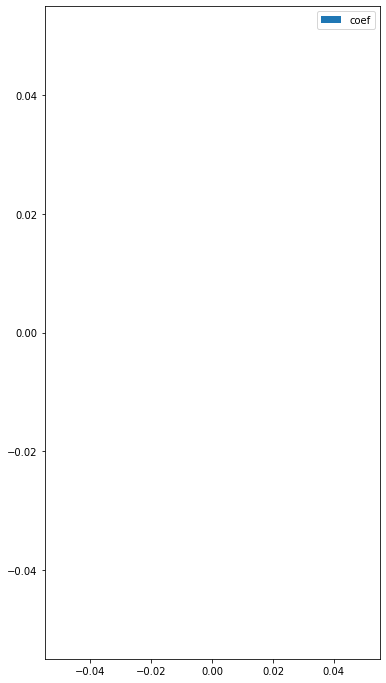

In [119]:
en_alpha = study_lr.best_params['alpha']
en_l1_ratio = study_lr.best_params['l1_ratio']

best_en = Pipeline([('scaler', StandardScaler()),
                    ('en', ElasticNet(alpha=en_alpha, l1_ratio=en_l1_ratio, max_iter=10000, random_state=23))])
best_en.fit(X_train, y_train)

print(best_en)

print("train_acc:", mean_absolute_error(y_train, best_en.predict(X_train)))
print("test_acc:", mean_absolute_error(y_val, best_en.predict(X_val)))

view_model_coefs(best_en.named_steps['en'], X_train)

In [122]:
model = best_en.named_steps['en']
feature_names = X_train.columns

coefficients = model.coef_

# coef_df = pd.DataFrame({'feature_name':feature_names,
#             'coef':coefficients})

# coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')

# top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
# top_20_features.plot.barh('feature_name', figsize=(6,12))



array([ 0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.28135125,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.00545164,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.08116532,  0.        ,
        0.13420133,  0.        , -0.02087873, -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.12773845, -0.        ,
        0.        , -0.        , -0.        ,  0.11931855,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.0435573 , -0.  

In [54]:
from sklearn.feature_selection import SequentialFeatureSelector

tscv = TimeSeriesSplit(5)

lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('lr', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, random_state=23))])

sfs_forward = SequentialFeatureSelector(
   lr_pipe, n_features_to_select=150, direction='forward', scoring='accuracy', cv=tscv, n_jobs=-1
)

sfs_forward.fit(X_train, y_train)

In [53]:
feature_names = X_train.columns
feature_names[sfs_forward.get_support()]


Index(['DEF_RATING_10', 'PLUS_MINUS_20', 'AST_3PM_20', 'PTS_OFF_TOV_opp_20'], dtype='object')

In [159]:
tscv = TimeSeriesSplit(5)

xgbc = xgb.XGBClassifier()

sfs_forward_xgb = SequentialFeatureSelector(
   xgbc, n_features_to_select=100, direction='forward', scoring='accuracy', cv=tscv, n_jobs=-1
)

sfs_forward_xgb.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

In [ ]:
sfs_pipe_lr = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(LogisticRegression(solver='saga',tol = 0.001, max_iter=1000, n_jobs=-1, random_state=23),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=2))])


sfs_pipe_lr.fit(X_train, y_train)



In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_lr.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_log

In [ ]:
sfs = SequentialFeatureSelector(lr, scoring = 'accuracy', cv=tscv, n_jobs=-1)

sfs.fit(rfe_features, y_train)

In [ ]:
selected_cols = rfe_features.iloc[:, sfs.support_].columns

In [ ]:
lr.fit(X_train[selected_cols], y_train)

print(lr.score(X_test[selected_cols], y_test))

In [ ]:

view_model_coefs(lr.named_steps['lr'], X_train[selected_cols])

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [ ]:
sfs_selected_cols_log = ['RECORD_team_diff', 'OREB_team_diff', 'DREB_team_diff', 'REB_team_diff',
       'STL_team_diff', 'TOV_team_diff', 'PLUS_MINUS_team_diff',
       'E_DEF_RATING_team_diff', 'PTS_OFF_TOV_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'ATS_DIFF_team_diff', 'FG2A_opp_diff',
       'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'TOV_opp_diff', 'E_OFF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'ATS_PCT_diff', 'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'DREB_PCT_opp_diff', 'TS_PCT_team_diff',
       'EFG_PCT_team_diff', 'EFG_PCT_opp_diff', 'AST_RATIO_team_diff',
       'TOV_PCT_team_diff', 'TOV_PCT_opp_diff', 'team_elo_pred',
       'elo_MOV_pred', 'SPREAD_team']

In [ ]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_log)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                                      penalty='l2', max_iter=10000,
                                                                     verbose=1, random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lr2_select_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=1)

In [ ]:
study_lr.trials_dataframe().sort_values(['value'])

In [ ]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('selector', ColumnTransformer([
    ("selector", "passthrough", sfs_selected_cols_log)
], remainder="drop")),
                    ('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, random_state=23))])
best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['logreg'], X_train[sfs_selected_cols_log])

In [ ]:
filename = '../models/best_lr_diffs_sfs'
joblib.dump(best_lr, filename)

### SGD Hinge (SVC Linear)

In [ ]:
sfs_pipe_sgd = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='hinge', random_state=23, alpha=0.03320641664870966),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

In [ ]:
sfs_selected_cols_hinge = ['RECORD_team_diff', 'FG2M_team_diff', 'FG3M_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'REB_team_diff', 'AST_team_diff', 'STL_team_diff',
       'PTS_team_diff', 'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_NET_RATING_team_diff', 'POSS_team_diff', 'PIE_team_diff',
       'PTS_OFF_TOV_team_diff', 'AST_2PM_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'UAST_3PM_team_diff', 'RECORD_opp_diff',
       'FG2M_opp_diff', 'FG2A_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff',
       'FTA_opp_diff', 'OREB_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PTS_opp_diff', 'PLUS_MINUS_opp_diff', 'E_DEF_RATING_opp_diff',
       'E_NET_RATING_opp_diff', 'PIE_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'TS_PCT_team_diff', 'EFG_PCT_team_diff',
       'EFG_PCT_opp_diff', 'AST_RATIO_team_diff', 'AST_RATIO_opp_diff',
       'TOV_PCT_opp_diff', 'elo_MOV_pred', 'SPREAD_team']

In [ ]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=5000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_hinge_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=10, show_progress_bar=True)

In [ ]:
sgd_alpha = study_sgd.best_params['alpha']
print('C:', sgd_alpha)

best_sgd_hinge = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=1000,
                                     random_state=23))])


best_sgd_hinge.fit(X_train, y_train)

print("best_svc:", best_sgd_hinge)


print("train_score:", best_sgd_hinge.score(X_train, y_train))
print("test_score:", best_sgd_hinge.score(X_test, y_test))

In [ ]:
filename = '../models/best_sgd_hinge_diffs_sfs'
joblib.dump(best_lr, filename)

### SGD modified_huber

In [ ]:
sfs_pipe_sgd_huber = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='modified_huber', random_state=23, alpha=0.56299),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd_huber.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

In [ ]:
sfs_selected_cols_huber = ['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'STL_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'PIE_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_2PM_team_diff', 'AST_3PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3A_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_3PM_opp_diff', 'UAST_2PM_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'TS_PCT_team_diff', 'AST_RATIO_team_diff',
       'AST_RATIO_opp_diff', 'TOV_PCT_opp_diff', 'ML_team']

In [ ]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_huber_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=10, show_progress_bar = True)

In [ ]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_huber = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])

print("best_sgd:", best_sgd_huber)

best_sgd_huber.fit(X_train, y_train)

print("train_score:", best_sgd_huber.score(X_train, y_train))
print("test_score:", best_sgd_huber.score(X_test, y_test))

view_model_coefs(best_sgd_huber.named_steps['sgd'], X_train[sfs_selected_cols_huber])

In [ ]:
filename = '../models/best_sgd_huber_diffs_sfs'

joblib.dump(best_sgd_huber, filename)

### LGBClassifier

In [ ]:
sfs_pipe_lgb = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_lgb.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_lgb.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_lgb = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_lgb

In [ ]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_lgb)], remainder="drop")),
        ('lgbc', lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=200, show_progress_bar=True)

In [ ]:
import 

In [ ]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=100, show_progress_bar=True)

In [ ]:
study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.load_study(study_name = study_name, storage = storage_name)

lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [ ]:
filename = '../models/best_lgbc_diffs'
joblib.dump(best_lgbc, filename)

In [ ]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [ ]:
best_lgbc = lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508)

In [ ]:
from sklearn.decomposition import PCA


### KNNeighbors

In [ ]:
sfs_pipe_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=0.99)),
                                    ('knn',
                                     SFS(KNeighborsClassifier(n_neighbors=47),
                                    k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_knn.fit(X_train, y_train)




In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_knn.named_steps['knn'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_knn = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_knn

In [ ]:
sfs_selected_cols_knn = ['FG2M_team_diff', 'FG2A_team_diff', 'FTM_team_diff', 'AST_team_diff',
       'BLK_team_diff', 'TOV_team_diff', 'PF_team_diff',
       'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_2PT_MR_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3M_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff']

In [ ]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    n_components = trial.suggest_float('n_components', 0.9, 0.99)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=n_neighbors))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 50, 4).tolist(),
               'n_components':np.linspace(0.9, 0.99, 10).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

In [ ]:
study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_knn = optuna.load_study(study_name = study_name, 
                               storage = storage_name)


best_n = study_knn.best_trial.params['n_neighbors']
best_n_components = study_knn.best_trial.params['n_components']


best_knn = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=best_n))])

print("best_knn:", best_knn)

best_knn.fit(X_train, y_train)

print("train_score:", best_knn.score(X_train, y_train))
print("test_score:", best_knn.score(X_test, y_test))

In [ ]:
filename = 'best_knn_diffs_sfs'

joblib.dump(best_knn, filename)

### Random Forest

In [ ]:
sfs_pipe_rf = SFS(RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23), k_features=25, cv=tscv, scoring='accuracy', floating=True, verbose=1)


sfs_pipe_rf.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

In [ ]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])
    
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_rf2_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=250)

In [ ]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])

print(best_rf)

In [ ]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['STL_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                                   'AST_2PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'STL_opp_diff',
                                                   'BLK_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'OREB_PCT_team_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff',
                                                   'team_elo_pred'])])),
                ('rf',
                 RandomForestClassifier(max_depth=5,
                                        min_samples_leaf=0.041549315118501726,
                                        min_samples_split=0.10343617670917564,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

In [ ]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['REB_team_diff',
                                                   'AST_3PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'DREB_opp_diff',
                                                   'REB_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'AST_2PM_opp_diff',
                                                   'ATS_DIFF_opp_diff',
                                                   'TEAM_COVERED_opp_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff'])])),
                ('rf',
                 RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

In [ ]:
view_model_coefs(best_rf.named_steps['rf'], X_train[sfs_selected_cols_rf])

## Stacked Classifier

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

### with select features

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_mid_16, cutoff_17, cutoff_mid_17, cutoff_18, cutoff_mid_18,
           cutoff_19, cutoff_mid_19, cutoff_20, cutoff_mid_20, cutoff_21, cutoff_mid_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_sgd_hinge, best_sgd, best_lgbc, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
stacked_clf.fit(X_train, y_train)
y_preds = stacked_clf.predict(X_train)


In [ ]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_svc, best_sgd, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


In [ ]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


## Make Predictions

ETL Pipeline

### Update Date

In [ ]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



In [ ]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [ ]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df



In [ ]:
X_train.columns

In [ ]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

In [ ]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [ ]:
from datetime import date
date.today()

In [ ]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


In [ ]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=prev_season_final_elo.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [ ]:
X_train

In [ ]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread,
                                  home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
#     home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
#     away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
#     new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    home_rating_i = home_stats.iloc[-1, -5]
    away_rating_i = away_stats.iloc[-1, -5]
    
    diffs['team_rating_i'] = np.nan
    diffs['opp_rating_i'] = np.nan
    
    diffs.at[0, 'team_rating_i'] = home_rating_i
    diffs.at[0, 'opp_rating_i'] = away_rating_i
    
    diffs.at[1, 'team_rating_i'] = away_rating_i
    diffs.at[1, 'opp_rating_i'] = home_rating_i
    
    diffs.at[0, 'team_elo_pred'] = elo_prediction(home_rating_i+69, away_rating_i)
    diffs.at[1, 'team_elo_pred'] = elo_prediction(away_rating_i, home_rating_i+69)

    diffs['elo_MOV_pred'] = np.nan
    diffs.at[0, 'elo_MOV_pred'] = round((home_rating_i + 69 - away_rating_i)/28, 2)
    diffs.at[1, 'elo_MOV_pred'] = round((away_rating_i - (home_rating_i + 69))/28, 2)

    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = home_spread
    diffs.at[1, 'SPREAD_team'] = away_spread 
    
    diffs.at[0, 'ML_team'] = home_ml
    diffs.at[1, 'ML_team'] = away_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


In [ ]:
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spreads_df(todays_spreads)

todays_mls = get_days_moneylines(todays_date)
todays_mls = clean_moneyline_df(todays_mls)

todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)
todays_lines

In [ ]:
web = 'https://sportsbook.draftkings.com/leagues/basketball/88670846?category=game-lines&subcategory=game'
path = '../chromedriver.exe'
driver = webdriver.Chrome(path)
driver.get(web)
sleep(2)

teams = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/th/a/div/div[2]/span/div/div')
# spreads = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[4]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[1]/div/div/div/div[1]/span')
# moneylines = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[4]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[3]/div/div/div/div/div[2]/span')
'//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr[2]/th/a/div/div[2]/span/div/div'
'//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[2]/table/tbody/tr[1]/th/a/div/div[2]/span/div/div'
print(teams)

In [ ]:
from selenium import webdriver
from time import sleep

def get_draftking_lines(date):
    """
    INPUTS
    date: "yyyy-mm-dd"
    OUPUTS 
    dataframe with game spreads
    """
    gm_dates = []
    away_teams = []
    home_teams = []
    away_spreads = []
    home_spreads = []
    away_moneylines = []
    home_moneylines = []

    web = 'https://sportsbook.draftkings.com/leagues/basketball/88670846?category=game-lines&subcategory=game'
    path = '../chromedriver.exe'
    driver = webdriver.Chrome(path)
    driver.get(web)
    sleep(2)
    
    teams = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/th/a/div/div[2]/span/div/div')
    spreads = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[1]/div/div/div/div[1]/span')
    moneylines = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[3]/div/div/div/div/div[2]/span')

    print(len(teams), len(spreads), len(moneylines))
    
    for i in range(len(teams)):
        if i%2==0:
            away_teams.append(teams[i].text)
            away_spreads.append(spreads[i].text)
            away_moneylines.append(moneylines[i].text)
            gm_dates.append(date)
        else:
            home_teams.append(teams[i].text)
            home_spreads.append(spreads[i].text)
            home_moneylines.append(moneylines[i].text)    

#     driver.quit()

    todays_lines = pd.DataFrame({"game_date":gm_dates,
                'away_team':away_teams,
                'home_team':home_teams,
                'away_spread':away_spreads,
                'home_spread':home_spreads,
                'away_moneyline':away_moneylines,
                'home_moneyline':home_moneylines})
    
    return todays_lines


get_draftking_lines('2021-11-09')

In [ ]:
from src.models.model_preparation import get_draftking_lines, clean_draftking_lines

todays_date = datetime.today().strftime('%Y-%m-%d')


todays_lines = get_draftking_lines(todays_date)

# todays_lines = clean_draftking_lines(todays_lines)

todays_lines

In [ ]:
todays_lines

### Make Predictions

In [ ]:
clean_data = pd.read_csv("../data/clean/processed_data.csv")

clean_data



In [ ]:
def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_lines = get_draftking_lines(todays_date)
    todays_lines = clean_draftking_lines(todays_lines)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_spread = row['home_spread'] 
        away_spread = row['away_spread']
        home_ml = row['home_moneyline']
        away_ml = row['away_moneyline']
        game_date = row['game_date']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [ ]:
final_stacked_clf

In [ ]:
final_stacked_clf = joblib.load('../models/finalized_stacked_model_sfs')

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

final_stacked_clf.fit(X_full, y_full)


filename = '../models/finalized_stacked_model_retrain-21-12-20'

joblib.dump(final_stacked_clf, filename)

In [ ]:
final_stacked_model = joblib.load('../models/finalized_stacked_model_sfs')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")

In [ ]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

stacked_clf2.fit(X_full, y_full)

filename = '../models/final_stacked_clf_v2-21-12-20'

joblib.dump(stacked_clf2, filename)

In [ ]:
def main(conn, season, model, prev_season_elo, append = True):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    if append == True:
        todays_predictions.to_csv("../results/predictions_2021.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [ ]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")
todays_predictions = main(connection, 2021, final_stacked_model, prev_season_elo, append=True)

connection.close()

todays_predictions

In [ ]:
season = 2021
home_team = 'PHI'
away_team = 'NYK'
home_spread = -3.5
away_spread = -home_spread
home_ml = 1.63
away_ml = 2.4

conn = sqlite3.connect('../data/nba.db')

# update_all_data(conn, season=season)

df = load_current_season_team_data(conn, season)

df = clean_team_data(df)

df = prep_for_aggregation(df)

spreads, moneylines = load_current_season_betting_data(conn, 2021)
clean_moneylines = clean_moneyline_df(df=moneylines)
clean_spreads = clean_spreads_df(df=spreads)


full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
full_df = create_matchups(full_df)
full_df = get_team_and_opp_ewm(full_df)

full_df = add_percentage_features(full_df)
full_df = add_rest_days_for_model(full_df)

current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)

matchup = create_matchup_rows_for_model(full_df, home_team, away_team,
                                        home_spread, away_spread, home_ml, away_ml)

conn.close()

# print(matchup)

# full_df
matchup



In [ ]:
final_stacked_model.predict_proba(matchup)